In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from vis.utils import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (InceptionV3 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False, pooling=None)

In [7]:
print("Extracting features from VGG16 layers ...")
bnfeatures = base_model.predict(X)

Extracting features from VGG16 layers ...


In [8]:
print(bnfeatures)

[[[[  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   ..., 
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]]

  [[  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   ..., 
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.    

In [9]:
bnfeatures.shape

(10136, 7, 7, 512)

In [10]:
# Adding a custom top layer to the model
x = Flatten(name='flatten')(base_model.output)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
# Creating the top model for pre-training
bottleneck_features = Input(shape=bnfeatures.shape[1:], name='bottleneck_features')
x = Flatten(name='flatten')(bottleneck_features)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
top_model = Model(inputs=bottleneck_features, outputs=predictions)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_features (InputLa (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 20)                81940     
Total params: 119,627,796
Trainable params: 119,627,796
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
tophistory = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='virussign-vgg16-pretrained-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()
init_top_weights = top_model.get_weights()

In [ ]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    bnfeatures_train = bnfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    bnfeatures_test = bnfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
  
    print("[%d] Pre-training the top model ..." %(i))

    top_model.set_weights(init_top_weights)

    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    start = time.time()
    h = top_model.fit(bnfeatures_train, Y_train, validation_data=(bnfeatures_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    tophistory.append(h)
    
    pretrained_fc1_weights = top_model.layers[-3].get_weights()
    pretrained_fc2_weights = top_model.layers[-2].get_weights()
    pretrained_top_weights = top_model.layers[-1].get_weights()
          
    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Pre-trained acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
   
    print("[%d] Fine-tuning the model ..." %(i))

    model.set_weights(init_weights)
    model.layers[-3].set_weights(pretrained_fc1_weights)
    model.layers[-2].set_weights(pretrained_fc2_weights)
    model.layers[-1].set_weights(pretrained_top_weights)

    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Pre-trained acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))    
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
        
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Pre-training the top model ...
[0] Initial acurracy (top_model): 0.0938
Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 16s - loss: 14.2128 - acc: 0.1152 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 2/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 3/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 4/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 5/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 6/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 7/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.30

9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 64/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 65/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 66/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 67/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 68/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 69/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 70/100
9112/9112 [==============================] - 8s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080

9112/9112 [==============================] - 111s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 26/100
9112/9112 [==============================] - 120s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 27/100
9112/9112 [==============================] - 120s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 28/100
9112/9112 [==============================] - 124s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 29/100
9112/9112 [==============================] - 117s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 30/100
9112/9112 [==============================] - 118s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 31/100
9112/9112 [==============================] - 123s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 32/100
9112/9112 [==============================] - 121s - loss: 14.2908 - acc: 0.1134 - v

9112/9112 [==============================] - 115s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 88/100
9112/9112 [==============================] - 124s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 89/100
9112/9112 [==============================] - 117s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 90/100
9112/9112 [==============================] - 116s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 91/100
9112/9112 [==============================] - 118s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 92/100
9112/9112 [==============================] - 118s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 93/100
9112/9112 [==============================] - 115s - loss: 14.2908 - acc: 0.1134 - val_loss: 14.3080 - val_acc: 0.1123
Epoch 94/100
9112/9112 [==============================] - 117s - loss: 14.2908 - acc: 0.1134 - v

9114/9114 [==============================] - 8s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 50/100
9114/9114 [==============================] - 7s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 51/100
9114/9114 [==============================] - 7s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 52/100
9114/9114 [==============================] - 7s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 53/100
9114/9114 [==============================] - 8s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 54/100
9114/9114 [==============================] - 7s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 55/100
9114/9114 [==============================] - 7s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 56/100
9114/9114 [==============================] - 8s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044

9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 12/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 13/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 14/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 15/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 16/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 17/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 18/100
9114/9114 [==============================] - 102s - loss: 14.2912 - acc: 0.1133 - v

9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 74/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 75/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 76/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 77/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 78/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 79/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - val_loss: 14.3044 - val_acc: 0.1125
Epoch 80/100
9114/9114 [==============================] - 101s - loss: 14.2912 - acc: 0.1133 - v

9116/9116 [==============================] - 7s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 35/100
9116/9116 [==============================] - 8s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 36/100
9116/9116 [==============================] - 7s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 37/100
9116/9116 [==============================] - 7s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 38/100
9116/9116 [==============================] - 8s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 39/100
9116/9116 [==============================] - 7s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 40/100
9116/9116 [==============================] - 7s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 41/100
9116/9116 [==============================] - 7s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492

9116/9116 [==============================] - 8s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 98/100
9116/9116 [==============================] - 7s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 99/100
9116/9116 [==============================] - 7s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 100/100
9116/9116 [==============================] - 7s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
[2] Pre-trained acurracy (top_model): 0.0353
[2] Fine-tuning the model ...
Train on 9116 samples, validate on 1020 samples
Epoch 1/100
9116/9116 [==============================] - 104s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 2/100
9116/9116 [==============================] - 102s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 3/100
9116/9116 [==============================] - 102s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 -

9116/9116 [==============================] - 102s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 59/100
9116/9116 [==============================] - 102s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 60/100
9116/9116 [==============================] - 102s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 61/100
9116/9116 [==============================] - 102s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 62/100
9116/9116 [==============================] - 101s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 63/100
9116/9116 [==============================] - 102s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 64/100
9116/9116 [==============================] - 102s - loss: 15.5470 - acc: 0.0354 - val_loss: 15.5492 - val_acc: 0.0353
Epoch 65/100
9116/9116 [==============================] - 102s - loss: 15.5470 - acc: 0.0354 - v

9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 20/100
9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 21/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 22/100
9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 23/100
9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 24/100
9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 25/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 26/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971

9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 83/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 84/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 85/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 86/100
9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 87/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 88/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 89/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971

9120/9120 [==============================] - 102s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 46/100
9120/9120 [==============================] - 102s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 49/100
9120/9120 [==============================] - 102s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 50/100
9120/9120 [==============================] - 102s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 51/100
9120/9120 [==============================] - 101s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 52/100
9120/9120 [==============================] - 102s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 53/100
9120/9120 [==============================] - 102s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 54/100
9120/9120 [==============================] - 102s - loss: 13.8895 - acc: 0.1383 - v

9120/9120 [==============================] - 8s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 9/100
9120/9120 [==============================] - 7s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 10/100
9120/9120 [==============================] - 7s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 11/100
9120/9120 [==============================] - 8s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 12/100
9120/9120 [==============================] - 7s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 13/100
9120/9120 [==============================] - 8s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 14/100
9120/9120 [==============================] - 7s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 15/100
9120/9120 [==============================] - 8s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 

9120/9120 [==============================] - 7s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 72/100
9120/9120 [==============================] - 7s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 73/100
9120/9120 [==============================] - 7s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 74/100
9120/9120 [==============================] - 7s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 75/100
9120/9120 [==============================] - 7s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 76/100
9120/9120 [==============================] - 7s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 77/100
9120/9120 [==============================] - 8s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 78/100
9120/9120 [==============================] - 7s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226

9120/9120 [==============================] - 102s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 34/100
9120/9120 [==============================] - 102s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 35/100
9120/9120 [==============================] - 102s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 36/100
9120/9120 [==============================] - 102s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 37/100
9120/9120 [==============================] - 102s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 38/100
9120/9120 [==============================] - 102s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 39/100
9120/9120 [==============================] - 102s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 40/100
9120/9120 [==============================] - 102s - loss: 13.7198 - acc: 0.1488 - v

9120/9120 [==============================] - 102s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 96/100
9120/9120 [==============================] - 101s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 97/100
9120/9120 [==============================] - 101s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 98/100
9120/9120 [==============================] - 101s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 99/100
9120/9120 [==============================] - 101s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
Epoch 100/100
9120/9120 [==============================] - 101s - loss: 13.7198 - acc: 0.1488 - val_loss: 13.7226 - val_acc: 0.1486
[4] Test acurracy: 0.1486 (10193.2549 s)
[5] Pre-training the top model ...
[5] Initial acurracy (top_model): 0.1048
Train on 9125 samples, validate on 1011 samples
Epoch 1/100
9125/9125 [==============================] - 8s -

9125/9125 [==============================] - 7s - loss: 15.5476 - acc: 0.0354 - val_loss: 15.5442 - val_acc: 0.0356
Epoch 58/100
9125/9125 [==============================] - 7s - loss: 15.5476 - acc: 0.0354 - val_loss: 15.5442 - val_acc: 0.0356
Epoch 59/100
9125/9125 [==============================] - 7s - loss: 15.5476 - acc: 0.0354 - val_loss: 15.5442 - val_acc: 0.0356
Epoch 60/100
9125/9125 [==============================] - 7s - loss: 15.5476 - acc: 0.0354 - val_loss: 15.5442 - val_acc: 0.0356
Epoch 61/100
9125/9125 [==============================] - 7s - loss: 15.5476 - acc: 0.0354 - val_loss: 15.5442 - val_acc: 0.0356
Epoch 62/100
9125/9125 [==============================] - 8s - loss: 15.5476 - acc: 0.0354 - val_loss: 15.5442 - val_acc: 0.0356
Epoch 63/100
9125/9125 [==============================] - 7s - loss: 15.5476 - acc: 0.0354 - val_loss: 15.5442 - val_acc: 0.0356
Epoch 64/100
9125/9125 [==============================] - 7s - loss: 15.5476 - acc: 0.0354 - val_loss: 15.5442

In [33]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.0981


In [34]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

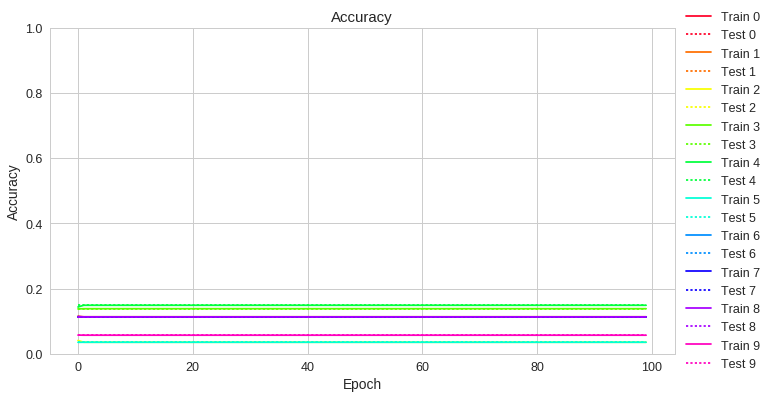

In [35]:
plot_acc(tophistory)

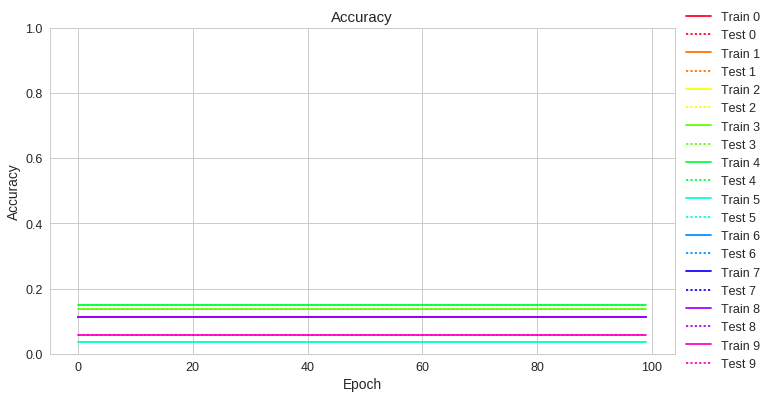

In [36]:
plot_acc(history)

In [37]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

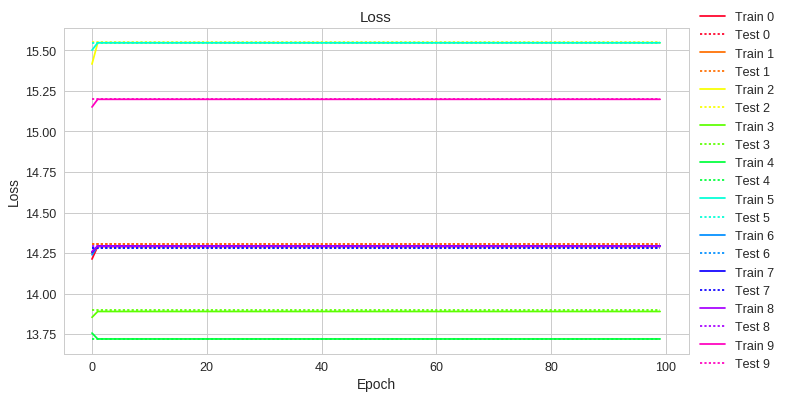

In [38]:
plot_loss(tophistory)

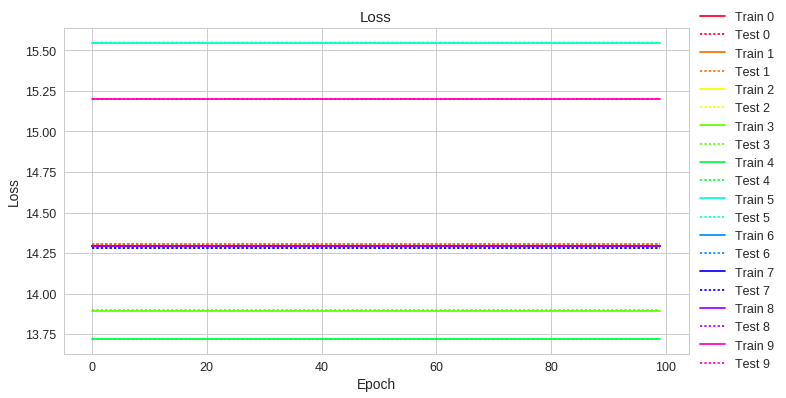

In [39]:
plot_loss(history)

Plotting the confusion matrix


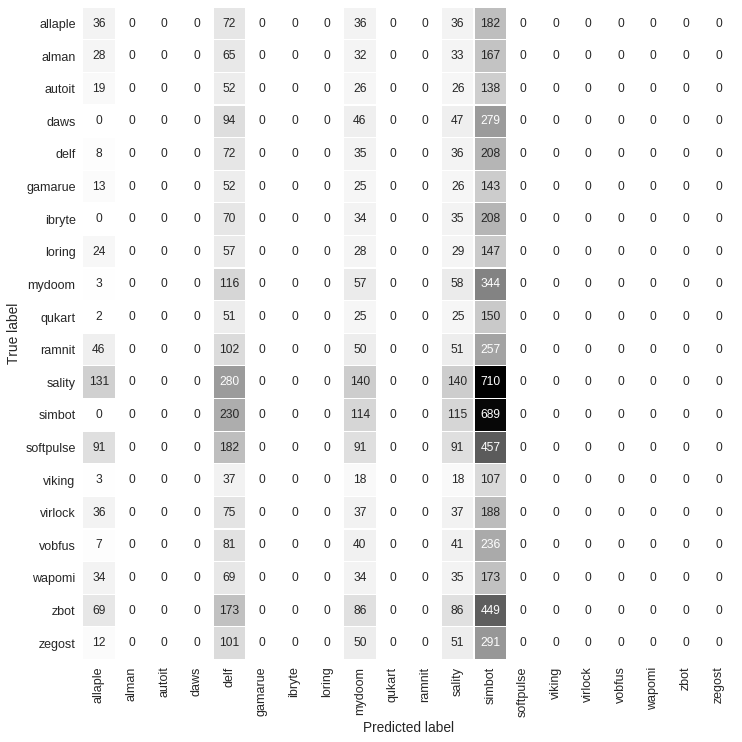

In [40]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


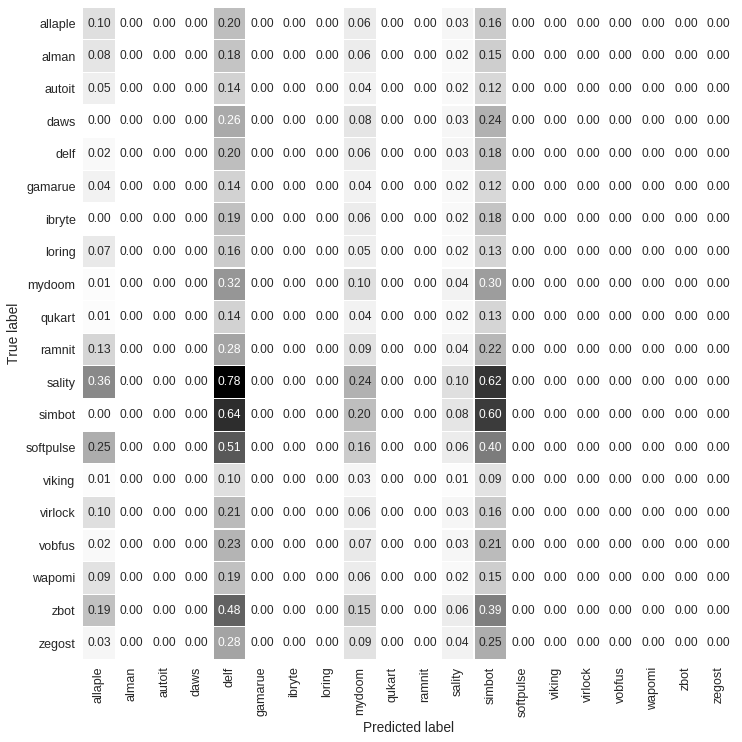

In [41]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [42]:
for h in tophistory:
    print(h.history)

{'acc': [0.11523266022827042, 0.11336698859956204, 0.11336698859956204, 0.11336698858647937, 0.1133669885930207, 0.11336698858647937, 0.1133669885930207, 0.11336698858975003, 0.11336698861264471, 0.1133669885930207, 0.11336698858975003, 0.11336698858975003, 0.11336698858975003, 0.11336698858975003, 0.11336698859956204, 0.11336698858647937, 0.11336698858647937, 0.11336698859956204, 0.11336698858647937, 0.1133669885930207, 0.11336698859956204, 0.11336698858975003, 0.11336698858647937, 0.11336698859956204, 0.1133669885930207, 0.11336698858975003, 0.11336698859956204, 0.11336698859956204, 0.11336698858647937, 0.11336698858975003, 0.11336698858647937, 0.11336698859956204, 0.11336698858647937, 0.11336698858647937, 0.11336698858647937, 0.11336698861264471, 0.11336698859956204, 0.11336698858975003, 0.11336698858975003, 0.11336698861264471, 0.11336698861264471, 0.11336698858975003, 0.1133669885930207, 0.11336698858647937, 0.1133669885930207, 0.11336698859956204, 0.11336698858647937, 0.113366988

In [43]:
for h in history:
    print(h.history)

{'acc': [0.11336698858647937, 0.11336698861264471, 0.1133669885930207, 0.1133669885930207, 0.11336698858975003, 0.11336698858975003, 0.11336698858647937, 0.11336698858647937, 0.11336698859956204, 0.11336698859956204, 0.11336698858647937, 0.11336698858975003, 0.1133669885930207, 0.11336698858647937, 0.1133669885930207, 0.11336698861264471, 0.11336698858975003, 0.1133669885930207, 0.11336698859956204, 0.1133669885930207, 0.11336698858647937, 0.11336698858647937, 0.11336698858975003, 0.11336698858647937, 0.11336698858647937, 0.11336698858647937, 0.11336698859956204, 0.1133669885930207, 0.11336698858647937, 0.1133669885930207, 0.11336698858647937, 0.11336698858647937, 0.11336698858975003, 0.11336698858647937, 0.11336698859956204, 0.11336698858647937, 0.1133669885930207, 0.11336698861264471, 0.1133669885930207, 0.1133669885930207, 0.11336698858647937, 0.11336698859956204, 0.1133669885930207, 0.11336698858647937, 0.1133669885930207, 0.11336698858647937, 0.11336698859956204, 0.113366988589750

In [44]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

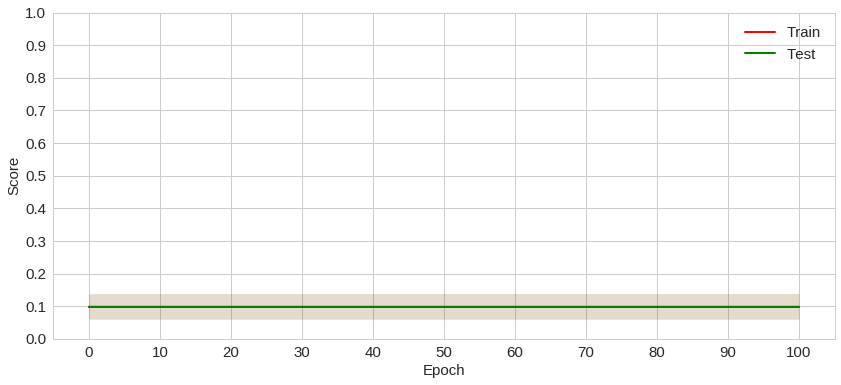

In [45]:
plot_mean_acc(tophistory)

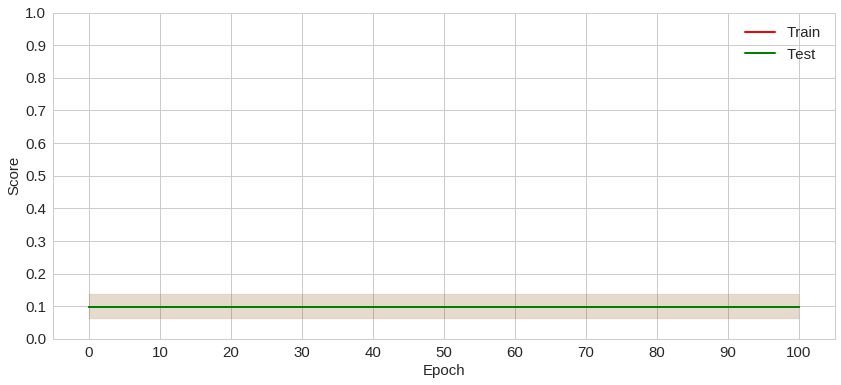

In [46]:
plot_mean_acc(history)

In [47]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

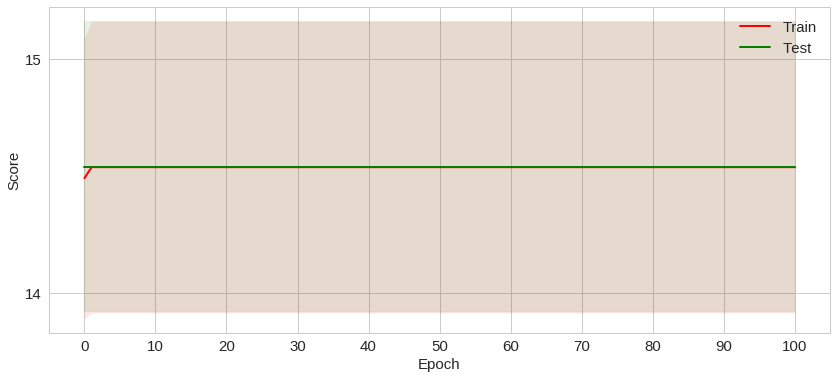

In [48]:
plot_mean_loss(tophistory)

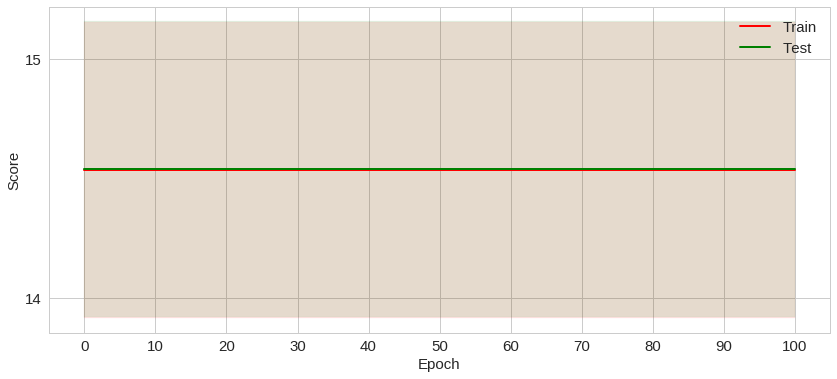

In [49]:
plot_mean_loss(history)

In [51]:
tophistory = [{'acc': [0.11523266022827042, 0.11336698859956204, 0.11336698859956204, 0.11336698858647937, 0.1133669885930207, 0.11336698858647937, 0.1133669885930207, 0.11336698858975003, 0.11336698861264471, 0.1133669885930207, 0.11336698858975003, 0.11336698858975003, 0.11336698858975003, 0.11336698858975003, 0.11336698859956204, 0.11336698858647937, 0.11336698858647937, 0.11336698859956204, 0.11336698858647937, 0.1133669885930207, 0.11336698859956204, 0.11336698858975003, 0.11336698858647937, 0.11336698859956204, 0.1133669885930207, 0.11336698858975003, 0.11336698859956204, 0.11336698859956204, 0.11336698858647937, 0.11336698858975003, 0.11336698858647937, 0.11336698859956204, 0.11336698858647937, 0.11336698858647937, 0.11336698858647937, 0.11336698861264471, 0.11336698859956204, 0.11336698858975003, 0.11336698858975003, 0.11336698861264471, 0.11336698861264471, 0.11336698858975003, 0.1133669885930207, 0.11336698858647937, 0.1133669885930207, 0.11336698859956204, 0.11336698858647937, 0.1133669885930207, 0.1133669885930207, 0.11336698858975003, 0.11336698858647937, 0.1133669885930207, 0.1133669885930207, 0.11336698861264471, 0.11336698858975003, 0.11336698859956204, 0.11336698858647937, 0.11336698858647937, 0.1133669885930207, 0.1133669885930207, 0.11336698858647937, 0.1133669885930207, 0.11336698858975003, 0.11336698858975003, 0.11336698858975003, 0.11336698861264471, 0.1133669885930207, 0.11336698858647937, 0.11336698858647937, 0.11336698861264471, 0.1133669885930207, 0.11336698858647937, 0.11336698858647937, 0.11336698859956204, 0.1133669885930207, 0.11336698858975003, 0.11336698858975003, 0.11336698858647937, 0.1133669885930207, 0.11336698859956204, 0.11336698859956204, 0.11336698858975003, 0.11336698858647937, 0.1133669885930207, 0.11336698859956204, 0.1133669885930207, 0.11336698861264471, 0.11336698859956204, 0.11336698858647937, 0.11336698858975003, 0.11336698858647937, 0.11336698858975003, 0.1133669885930207, 0.11336698859956204, 0.1133669885930207, 0.11336698858647937, 0.11336698859956204, 0.11336698861264471, 0.1133669885930207, 0.1133669885930207], 'loss': [14.212822275270591, 14.290835383903362, 14.290835296825112, 14.290835337852364, 14.290835309384475, 14.290835364645673, 14.290835396462725, 14.290835367994836, 14.290835329479455, 14.290835362971091, 14.29083538139149, 14.290835421581452, 14.290835287614911, 14.290835321106547, 14.2908353437134, 14.290835304360728, 14.290835331154037, 14.290835390601689, 14.290835355435473, 14.290835383066073, 14.290835316920091, 14.290835388089818, 14.290835398137308, 14.290835350411728, 14.290835302686148, 14.290835327804874, 14.290835363808382, 14.290835363808382, 14.290835315245511, 14.290835394788145, 14.290835332828619, 14.290835363808382, 14.290835317757383, 14.290835331154037, 14.290835351249019, 14.290835396462725, 14.290835330316746, 14.290835374693163, 14.290835354598181, 14.290835305198019, 14.290835383066073, 14.290835341201527, 14.290835309384475, 14.29083532445571, 14.290835309384475, 14.290835417394998, 14.290835346225274, 14.290835302686148, 14.290835336177782, 14.290835374693163, 14.290835337852364, 14.290835383066073, 14.290835349574436, 14.290835347899854, 14.290835388089818, 14.290835377205036, 14.290835290964075, 14.290835357947346, 14.290835383066073, 14.2908353160828, 14.290835348737145, 14.290835342876109, 14.290835341201527, 14.290835347899854, 14.290835367994836, 14.290835365482963, 14.290835376367745, 14.290835311059055, 14.290835337852364, 14.290835374693163, 14.290835342876109, 14.290835339526947, 14.290835337852364, 14.290835337015073, 14.290835329479455, 14.290835367994836, 14.29083531440822, 14.290835319431965, 14.290835322781128, 14.290835323618419, 14.290835350411728, 14.290835361296509, 14.290835337852364, 14.290835376367745, 14.2908353437134, 14.290835356272764, 14.290835383066073, 14.290835350411728, 14.290835339526947, 14.290835421581452, 14.290835346225274, 14.290835341201527, 14.290835349574436, 14.290835363808382, 14.290835356272764, 14.290835337852364, 14.290835363808382, 14.290835365482963, 14.2908353897644, 14.290835403161052], 'val_acc': [0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875], 'val_loss': [14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827]},
{'acc': [0.11290322582934126, 0.11334211104613845, 0.11334211105431333, 0.11334211104613845, 0.11334211108374287, 0.11334211105431333, 0.11334211104613845, 0.11334211104205101, 0.11334211106085322, 0.11334211104205101, 0.11334211104613845, 0.11334211106085322, 0.11334211104613845, 0.11334211114260197, 0.11334211104205101, 0.11334211106085322, 0.11334211104613845, 0.11334211104205101, 0.11334211104613845, 0.11334211104613845, 0.11334211105431333, 0.11334211105431333, 0.11334211106085322, 0.11334211104205101, 0.11334211109028276, 0.11334211106085322, 0.11334211105431333, 0.11334211106085322, 0.11334211106085322, 0.11334211104613845, 0.11334211104205101, 0.11334211104205101, 0.11334211108374287, 0.11334211106085322, 0.11334211104613845, 0.11334211103796357, 0.11334211106085322, 0.11334211109028276, 0.11334211106085322, 0.11334211106085322, 0.11334211105431333, 0.11334211105431333, 0.11334211104613845, 0.11334211104205101, 0.11334211104613845, 0.11334211104205101, 0.11334211105431333, 0.11334211109028276, 0.11334211104205101, 0.11334211106085322, 0.11334211106085322, 0.11334211104777342, 0.11334211104613845, 0.11334211104613845, 0.11334211109028276, 0.11334211109028276, 0.11334211104205101, 0.11334211106085322, 0.11334211104613845, 0.11334211104205101, 0.11334211104613845, 0.11334211105431333, 0.11334211107720298, 0.11334211105431333, 0.11334211104613845, 0.11334211104205101, 0.11334211104613845, 0.11334211106085322, 0.11334211104613845, 0.11334211103796357, 0.11334211109028276, 0.11334211104613845, 0.11334211108374287, 0.11334211106085322, 0.11334211105431333, 0.11334211105431333, 0.11334211104613845, 0.11334211109028276, 0.11334211104613845, 0.11334211103796357, 0.11334211105431333, 0.11334211105431333, 0.11334211104205101, 0.11334211109028276, 0.11334211105431333, 0.11334211106085322, 0.11334211106085322, 0.11334211104613845, 0.11334211104613845, 0.11334211104613845, 0.11334211105431333, 0.11334211104205101, 0.11334211105431333, 0.11334211104205101, 0.11334211106085322, 0.11334211106085322, 0.11334211109028276, 0.11334211109028276, 0.11334211103796357, 0.11334211104205101], 'loss': [14.250118778807201, 14.291236305487949, 14.291236288745806, 14.291236341692832, 14.291236296070494, 14.291236312812636, 14.291236312184806, 14.291236326624905, 14.291236340646449, 14.291236340018619, 14.29123639526769, 14.291236358016421, 14.291236288117975, 14.291236286653037, 14.291236353412332, 14.291236370154476, 14.291236328299119, 14.291236333321761, 14.291236345669091, 14.291236328299119, 14.29123634901752, 14.291236322230091, 14.291236327252735, 14.291236340018619, 14.291236327880565, 14.291236363457619, 14.291236332903207, 14.291236376851332, 14.29123631385902, 14.291236265306805, 14.291236393593476, 14.29123631323119, 14.291236289373636, 14.29123636073702, 14.291236314905404, 14.291236385222405, 14.291236387524449, 14.291236374758565, 14.291236309882761, 14.291236320555877, 14.291236322230091, 14.291236328926949, 14.291236401964547, 14.291236333321761, 14.291236258609949, 14.291236306534332, 14.291236282048949, 14.291236321183707, 14.291236306534332, 14.291236293768449, 14.291236307162162, 14.291236357388591, 14.29123630151169, 14.291236321602261, 14.29123631448685, 14.291236327880565, 14.291236326624905, 14.291236293768449, 14.29123630151169, 14.29123631323119, 14.291236352365949, 14.291236315533235, 14.291236311138421, 14.291236312812636, 14.291236361783405, 14.291236373502905, 14.291236328299119, 14.291236307162162, 14.29123625463369, 14.291236331647546, 14.291236394849136, 14.291236334995975, 14.291236309464207, 14.291236280374735, 14.291236359690636, 14.291236366387494, 14.291236338972235, 14.29123634127428, 14.291236321602261, 14.291236331647546, 14.29123634901752, 14.291236322230091, 14.291236326624905, 14.29123631448685, 14.29123627932835, 14.291236300465306, 14.291236276398475, 14.291236332275377, 14.291236292094235, 14.291236352365949, 14.291236286025207, 14.291236319928046, 14.291236312812636, 14.291236366806046, 14.291236307162162, 14.291236307162162, 14.291236301093136, 14.291236274305707, 14.291236304860119, 14.291236293140619], 'val_acc': [0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033], 'val_loss': [14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739]},
{'acc': [0.040807371654234315, 0.035432207118188563, 0.035432207118188563, 0.035432207113284715, 0.035432207108380867, 0.035432207113284715, 0.035432207113284715, 0.035432207118188563, 0.035432207113284715, 0.035432207108380867, 0.035432207118188563, 0.035432207108380867, 0.035432207113284715, 0.035432207113284715, 0.035432207118188563, 0.035432207108380867, 0.035432207118188563, 0.035432207108380867, 0.03543220712799626, 0.035432207108380867, 0.035432207108380867, 0.035432207113284715, 0.035432207134534731, 0.035432207113284715, 0.035432207108380867, 0.035432207113284715, 0.035432207113284715, 0.035432207113284715, 0.035432207113284715, 0.035432207134534731, 0.035432207108380867, 0.035432207113284715, 0.035432207113284715, 0.035432207108380867, 0.035432207113284715, 0.035432207113284715, 0.035432207113284715, 0.035432207113284715, 0.035432207108380867, 0.035432207118188563, 0.035432207113284715, 0.035432207113284715, 0.035432207108380867, 0.035432207108380867, 0.035432207113284715, 0.035432207108380867, 0.035432207118188563, 0.035432207108380867, 0.035432207113284715, 0.035432207113284715, 0.035432207113284715, 0.035432207118188563, 0.035432207108380867, 0.035432207108380867, 0.035432207108380867, 0.035432207118188563, 0.035432207113284715, 0.035432207118188563, 0.035432207108380867, 0.035432207108380867, 0.035432207108380867, 0.035432207113284715, 0.035432207113284715, 0.035432207108380867, 0.035432207118188563, 0.035432207113284715, 0.035432207108380867, 0.035432207118188563, 0.035432207113284715, 0.035432207108380867, 0.035432207108380867, 0.035432207134534731, 0.035432207113284715, 0.035432207113284715, 0.035432207108380867, 0.035432207134534731, 0.035432207113284715, 0.035432207108380867, 0.035432207108380867, 0.035432207108380867, 0.035432207113284715, 0.035432207118188563, 0.035432207118188563, 0.035432207113284715, 0.035432207113284715, 0.035432207113284715, 0.035432207118188563, 0.035432207134534731, 0.035432207118188563, 0.035432207113284715, 0.035432207113284715, 0.035432207118188563, 0.035432207108380867, 0.035432207118188563, 0.035432207118188563, 0.035432207113284715, 0.035432207134534731, 0.035432207113284715, 0.035432207134534731, 0.035432207108380867], 'loss': [15.415824886789025, 15.546995467604017, 15.546995467604017, 15.546995467185555, 15.546995439985542, 15.546995500662495, 15.546995480576332, 15.54699549438557, 15.546995480576332, 15.546995493548646, 15.546995480994793, 15.546995493548646, 15.546995473880944, 15.546995507357883, 15.54699549438557, 15.546995473462482, 15.546995474299406, 15.546995460071706, 15.546995471370174, 15.54699548015787, 15.546995460071706, 15.546995467185555, 15.546995497733263, 15.546995460490168, 15.54699548015787, 15.546995480576332, 15.546995473880944, 15.546995480576332, 15.546995487271719, 15.546995497733263, 15.546995473462482, 15.546995487271719, 15.546995487271719, 15.546995486853257, 15.546995480576332, 15.54699545379478, 15.546995500662495, 15.546995473880944, 15.546995460071706, 15.546995467604017, 15.546995460490168, 15.546995460490168, 15.546995486853257, 15.546995466767093, 15.546995493967108, 15.546995466767093, 15.546995460908629, 15.546995486853257, 15.546995473880944, 15.546995480576332, 15.546995473880944, 15.546995467604017, 15.546995473462482, 15.546995460071706, 15.546995453376319, 15.546995501080957, 15.546995487271719, 15.546995454213242, 15.546995460071706, 15.54699548015787, 15.54699548015787, 15.546995487271719, 15.546995500662495, 15.546995500244034, 15.546995474299406, 15.546995447099391, 15.546995466767093, 15.546995487690181, 15.546995487271719, 15.54699548015787, 15.54699548015787, 15.5469954776471, 15.546995460490168, 15.546995487271719, 15.546995493548646, 15.546995470951712, 15.546995473880944, 15.546995473462482, 15.546995473462482, 15.546995473462482, 15.546995473880944, 15.546995454213242, 15.546995454213242, 15.546995460490168, 15.546995460490168, 15.546995480576332, 15.546995487690181, 15.546995497733263, 15.546995480994793, 15.546995493967108, 15.546995507357883, 15.546995467604017, 15.54699548015787, 15.546995467604017, 15.546995460908629, 15.546995480576332, 15.546995484342487, 15.546995507357883, 15.546995470951712, 15.546995506939421], 'val_acc': [0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823], 'val_loss': [15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459]},
{'acc': [0.13760964912280702, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912], 'loss': [13.853428194815653, 13.889485978243643, 13.889485938088935, 13.889485907972904, 13.889485951473839, 13.889485941435161, 13.889485918011582, 13.889485891241776, 13.889485891241776, 13.889485931396484, 13.889485938088935, 13.889485867818196, 13.889485918011582, 13.88948590462668, 13.889485944781388, 13.889485921357807, 13.889485961512515, 13.889485968204967, 13.889485924704033, 13.889485911319131, 13.889485978243643, 13.889485921357807, 13.889485948127613, 13.889485897934227, 13.889485884549325, 13.88948586447197, 13.88948590462668, 13.889485948127613, 13.889485881203099, 13.88948590462668, 13.889485944781388, 13.889485938088935, 13.889485931396484, 13.889485954820064, 13.889485827663488, 13.889485911319131, 13.88948595816629, 13.889485918011582, 13.889485921357807, 13.889485894588002, 13.889485974897418, 13.889485887895551, 13.889485948127613, 13.889485978243643, 13.88948590462668, 13.889485931396484, 13.88948595816629, 13.889485884549325, 13.889485881203099, 13.889485891241776, 13.889485881203099, 13.889485921357807, 13.889485857779519, 13.889485911319131, 13.889485897934227, 13.889485907972904, 13.889485938088935, 13.889485847740843, 13.889485938088935, 13.889485877856874, 13.889485861125745, 13.889485931396484, 13.889485911319131, 13.889485877856874, 13.889485877856874, 13.889485971551192, 13.889485891241776, 13.889485974897418, 13.889485938088935, 13.889485914665356, 13.889485918011582, 13.889485837702166, 13.889485971551192, 13.889485938088935, 13.889485931396484, 13.889485924704033, 13.889485867818196, 13.889485911319131, 13.889485918011582, 13.889485907972904, 13.889485911319131, 13.889485901280453, 13.889485944781388, 13.889485924704033, 13.889485891241776, 13.889485951473839, 13.88948590462668, 13.88948590462668, 13.889485877856874, 13.889485867818196, 13.889485984936096, 13.889485924704033, 13.889485928050259, 13.889485998320998, 13.889485961512515, 13.889485867818196, 13.889485901280453, 13.88948590462668, 13.889485921357807, 13.889485921357807], 'val_acc': [0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119], 'val_loss': [13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244]},
{'acc': [0.14353070175438595, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281], 'loss': [13.756223507931358, 13.719821816159968, 13.719821796082615, 13.71982177600526, 13.719821742543003, 13.719821796082615, 13.719821792736388, 13.719821782697711, 13.719821786043937, 13.719821809467517, 13.719821822852419, 13.71982182954487, 13.719821796082615, 13.719821809467517, 13.719821809467517, 13.719821799428839, 13.719821836237323, 13.719821816159968, 13.719821809467517, 13.719821816159968, 13.719821782697711, 13.719821826198645, 13.719821739196778, 13.719821786043937, 13.719821779351486, 13.719821782697711, 13.719821725811874, 13.719821779351486, 13.71982182954487, 13.719821832891096, 13.719821782697711, 13.719821796082615, 13.719821842929774, 13.719821772659033, 13.719821796082615, 13.719821725811874, 13.719821742543003, 13.719821739196778, 13.719821779351486, 13.719821762620358, 13.719821789390162, 13.71982180612129, 13.719821779351486, 13.719821819506194, 13.71982177600526, 13.71982177600526, 13.719821809467517, 13.719821765966582, 13.719821809467517, 13.719821802775066, 13.719821832891096, 13.719821782697711, 13.719821725811874, 13.719821772659033, 13.71982175258168, 13.71982182954487, 13.719821749235454, 13.719821782697711, 13.719821762620358, 13.719821796082615, 13.719821796082615, 13.719821715773197, 13.719821789390162, 13.719821812813741, 13.719821782697711, 13.719821772659033, 13.719821745889229, 13.719821725811874, 13.719821755927907, 13.719821799428839, 13.71982175258168, 13.719821762620358, 13.719821772659033, 13.719821782697711, 13.719821839583547, 13.719821796082615, 13.719821792736388, 13.719821759274131, 13.719821745889229, 13.719821792736388, 13.719821809467517, 13.719821802775066, 13.719821802775066, 13.719821769312809, 13.719821755927907, 13.71982182954487, 13.719821755927907, 13.719821692349617, 13.71982177600526, 13.719821796082615, 13.719821816159968, 13.719821869699578, 13.719821782697711, 13.719821782697711, 13.719821782697711, 13.719821832891096, 13.719821812813741, 13.719821869699578, 13.719821782697711, 13.719821749235454], 'val_acc': [0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945], 'val_loss': [13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894]},
{'acc': [0.035178082194434454, 0.035397260273972601, 0.035397260276626236, 0.035397260273972601, 0.035397260273972601, 0.035397260276626236, 0.035397260284587131, 0.035397260289486143, 0.035397260289486143, 0.035397260276626236, 0.035397260276626236, 0.035397260279279863, 0.035397260276626236, 0.035397260279279863, 0.03539726030989869, 0.035397260273972601, 0.035397260276626236, 0.035397260279279863, 0.035397260273972601, 0.035397260276626236, 0.035397260276626236, 0.035397260279279863, 0.035397260279279863, 0.035397260273972601, 0.035397260276626236, 0.035397260279279863, 0.035397260279279863, 0.035397260279279863, 0.035397260279279863, 0.035397260279279863, 0.035397260273972601, 0.035397260279279863, 0.035397260284587131, 0.035397260276626236, 0.035397260273972601, 0.035397260273972601, 0.035397260284587131, 0.035397260289486143, 0.035397260276626236, 0.035397260276626236, 0.035397260276626236, 0.035397260273972601, 0.035397260279279863, 0.035397260273972601, 0.035397260273972601, 0.035397260276626236, 0.035397260279279863, 0.035397260273972601, 0.035397260273972601, 0.035397260289486143, 0.035397260289486143, 0.035397260273972601, 0.035397260276626236, 0.035397260276626236, 0.035397260273972601, 0.035397260276626236, 0.035397260276626236, 0.035397260276626236, 0.035397260279279863, 0.035397260276626236, 0.035397260279279863, 0.035397260279279863, 0.035397260273972601, 0.035397260276626236, 0.035397260273972601, 0.035397260273972601, 0.035397260284587131, 0.035397260284587131, 0.035397260284587131, 0.035397260276626236, 0.035397260284587131, 0.035397260279279863, 0.035397260273972601, 0.035397260276626236, 0.035397260279279863, 0.035397260273972601, 0.035397260279279863, 0.035397260276626236, 0.035397260279279863, 0.035397260279279863, 0.035397260279279863, 0.035397260276626236, 0.035397260279279863, 0.035397260279279863, 0.035397260279279863, 0.035397260276626236, 0.035397260276626236, 0.035397260279279863, 0.035397260273972601, 0.035397260289486143, 0.035397260276626236, 0.035397260273972601, 0.035397260279279863, 0.035397260289486143, 0.035397260289486143, 0.035397260279279863, 0.035397260276626236, 0.035397260279279863, 0.035397260279279863, 0.035397260276626236], 'loss': [15.501901742595516, 15.547558770166685, 15.547558748428136, 15.547558730033979, 15.547558736722763, 15.547558755116921, 15.54755876807644, 15.547558722927146, 15.54755877643742, 15.547558781872057, 15.547558775183273, 15.547558799221092, 15.547558768494488, 15.547558739022033, 15.547558765359121, 15.547558743411548, 15.547558737872398, 15.547558725644464, 15.547558736722763, 15.547558775183273, 15.547558775183273, 15.547558752399601, 15.547558752399601, 15.547558776855469, 15.547558755116921, 15.54755876577717, 15.547558752399601, 15.54755876577717, 15.54755876577717, 15.54755876577717, 15.5475587634779, 15.547558759088385, 15.547558764209485, 15.547558755116921, 15.547558716656411, 15.5475587634779, 15.547558757520703, 15.547558729615931, 15.547558784693887, 15.547558768494488, 15.547558795249625, 15.547558743411548, 15.547558759088385, 15.547558750100333, 15.547558750100333, 15.547558741739351, 15.547558779154738, 15.547558750100333, 15.547558750100333, 15.54755876305985, 15.547558749682283, 15.547558756789115, 15.547558791382672, 15.547558775183273, 15.547558743411548, 15.547558735050567, 15.547558781872057, 15.547558761805703, 15.547558725644464, 15.547558764627535, 15.547558759088385, 15.547558772465955, 15.547558743411548, 15.547558764627535, 15.547558750100333, 15.547558756789115, 15.547558748010086, 15.547558761387656, 15.547558741321302, 15.547558795249625, 15.54755876807644, 15.547558745710818, 15.547558743411548, 15.547558761805703, 15.54755876577717, 15.547558743411548, 15.547558732333249, 15.547558761805703, 15.54755876577717, 15.547558745710818, 15.547558739022033, 15.547558751249966, 15.547558745710818, 15.547558745710818, 15.547558732333249, 15.547558741739351, 15.547558731183614, 15.547558752399601, 15.547558770166685, 15.547558777482543, 15.547558764627535, 15.547558750100333, 15.547558759088385, 15.54755876305985, 15.547558742993498, 15.547558772465955, 15.547558735050567, 15.547558732333249, 15.547558732333249, 15.547558781872057], 'val_acc': [0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248], 'val_loss': [15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712]},
{'acc': [0.11350936783428481, 0.11318067273497907, 0.11318067275375451, 0.11318067276028509, 0.11318067273497907, 0.11318067274150967, 0.11318067273497907, 0.11318067273497907, 0.11318067273497907, 0.11318067273497907, 0.11318067276028509, 0.11318067273212194, 0.11318067275375451, 0.11318067275375451, 0.11318067273212194, 0.11318067276028509, 0.11318067276028509, 0.11318067275375451, 0.11318067275375451, 0.11318067274150967, 0.11318067280436654, 0.11318067273212194, 0.11318067273497907, 0.11318067276028509, 0.11318067273212194, 0.11318067276028509, 0.11318067274150967, 0.11318067274150967, 0.11318067273497907, 0.11318067274722393, 0.11318067275375451, 0.11318067274150967, 0.11318067272926483, 0.11318067275375451, 0.11318067276028509, 0.11318067274069334, 0.11318067272926483, 0.11318067273069339, 0.11318067273497907, 0.11318067275375451, 0.11318067276028509, 0.11318067273497907, 0.11318067273497907, 0.11318067273497907, 0.11318067273212194, 0.11318067274150967, 0.11318067273069339, 0.11318067273069339, 0.11318067273212194, 0.11318067274150967, 0.11318067276028509, 0.11318067276028509, 0.11318067275375451, 0.11318067274722393, 0.11318067276028509, 0.11318067274150967, 0.11318067274150967, 0.11318067275375451, 0.11318067276028509, 0.11318067273497907, 0.11318067275375451, 0.11318067275375451, 0.11318067275375451, 0.11318067274150967, 0.11318067274150967, 0.11318067273497907, 0.11318067276028509, 0.11318067276028509, 0.11318067273497907, 0.11318067273069339, 0.11318067273212194, 0.11318067275375451, 0.11318067274150967, 0.11318067274150967, 0.11318067276028509, 0.11318067273497907, 0.11318067274722393, 0.11318067273212194, 0.11318067276028509, 0.11318067273212194, 0.11318067273497907, 0.11318067275375451, 0.11318067275375451, 0.11318067274722393, 0.11318067275375451, 0.11318067273212194, 0.11318067275375451, 0.11318067275375451, 0.11318067273497907, 0.11318067274150967, 0.11318067276028509, 0.11318067273497907, 0.11318067273497907, 0.11318067274150967, 0.11318067273497907, 0.11318067274150967, 0.11318067274150967, 0.11318067274150967, 0.11318067274150967, 0.11318067274722393], 'loss': [14.239230960408346, 14.293838403174529, 14.293838382381148, 14.293838380709317, 14.293838392412125, 14.293838401502699, 14.293838403174529, 14.293838385724808, 14.29383839648721, 14.2938384191614, 14.293838371409766, 14.293838426580145, 14.293838402443104, 14.293838435879696, 14.293838435879696, 14.293838374022, 14.293838387396637, 14.293838355631873, 14.293838409130421, 14.293838417489571, 14.293838372350169, 14.293838439954781, 14.293838409861847, 14.293838434207867, 14.29383839983087, 14.293838400771273, 14.293838424176888, 14.293838461688566, 14.293838356363299, 14.293838434939293, 14.293838335569918, 14.293838408190018, 14.293838336301343, 14.293838395755785, 14.293838394083956, 14.293838461897545, 14.293838423236485, 14.293838404846358, 14.293838392412125, 14.293838422505059, 14.293838387396637, 14.293838389799891, 14.293838392412125, 14.293838403174529, 14.293838453329418, 14.293838384052977, 14.29383835803513, 14.293838431595633, 14.29383839983087, 14.293838343929066, 14.293838404846358, 14.293838360647362, 14.293838375693829, 14.29383839335253, 14.293838391471722, 14.293838384052977, 14.293838390740296, 14.29383839983087, 14.293838420833229, 14.293838459285311, 14.293838375693829, 14.293838369006512, 14.293838435879696, 14.293838434939293, 14.293838414877337, 14.293838449985758, 14.293838440895184, 14.293838427520548, 14.293838399099444, 14.29383835134781, 14.293838406518189, 14.29383841581774, 14.293838374753426, 14.293838421564654, 14.293838367334681, 14.293838369737935, 14.293838381440743, 14.293838389068467, 14.293838371409766, 14.293838386456233, 14.293838416549166, 14.293838395755785, 14.293838426580145, 14.293838430864207, 14.293838409130421, 14.293838453329418, 14.293838402443104, 14.293838395755785, 14.293838436611122, 14.293838404114933, 14.29383846095714, 14.293838416549166, 14.293838392412125, 14.293838388128062, 14.293838383112574, 14.29383837736566, 14.293838388128062, 14.293838394815381, 14.293838374753426, 14.293838404114933], 'val_acc': [0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494], 'val_loss': [14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017]},
{'acc': [0.11251095531542608, 0.11316827344434706, 0.11316827345087693, 0.11316827348352627, 0.11316827347046654, 0.11316827345740681, 0.11316827347046654, 0.11316827345087693, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827345740681, 0.11316827347046654, 0.11316827344434706, 0.11316827345740681, 0.11316827345087693, 0.11316827344434706, 0.11316827344434706, 0.11316827345087693, 0.11316827344597953, 0.11316827345740681, 0.11316827344434706, 0.11316827349658602, 0.11316827347046654, 0.11316827344434706, 0.11316827349658602, 0.11316827344434706, 0.11316827344434706, 0.11316827345740681, 0.11316827345740681, 0.11316827345740681, 0.11316827345087693, 0.11316827344434706, 0.11316827345087693, 0.11316827344597953, 0.11316827345740681, 0.11316827343128733, 0.11316827344434706, 0.11316827347046654, 0.11316827345740681, 0.11316827344434706, 0.11316827344434706, 0.11316827347046654, 0.11316827344434706, 0.11316827345087693, 0.11316827344434706, 0.11316827344597953, 0.113168273447612, 0.11316827345740681, 0.113168273447612, 0.113168273447612, 0.11316827343128733, 0.11316827349658602, 0.11316827345087693, 0.11316827345087693, 0.11316827345087693, 0.11316827345087693, 0.11316827347046654, 0.113168273447612, 0.11316827345740681, 0.11316827343128733, 0.11316827345740681, 0.11316827345740681, 0.11316827345740681, 0.11316827347046654, 0.11316827347046654, 0.11316827345087693, 0.11316827344434706, 0.11316827347046654, 0.11316827345740681, 0.11316827349658602, 0.11316827345087693, 0.11316827345087693, 0.11316827349658602, 0.11316827345087693, 0.113168273447612, 0.11316827349658602, 0.113168273447612, 0.11316827345740681, 0.11316827345087693, 0.11316827344434706, 0.11316827345740681, 0.11316827345087693, 0.11316827352270549, 0.11316827344434706, 0.11316827347046654, 0.11316827349658602, 0.11316827345087693, 0.11316827347046654, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827347046654, 0.11316827345087693, 0.11316827345740681, 0.11316827347046654, 0.11316827344434706, 0.11316827347046654, 0.11316827345740681, 0.11316827345740681], 'loss': [14.255557835049842, 14.294038260223362, 14.294038256044246, 14.294038166611159, 14.294038208402322, 14.294038238491957, 14.294038241835251, 14.294038256044246, 14.294038300342878, 14.294038233477018, 14.294038264402477, 14.294038267745771, 14.294038228462078, 14.294038264402477, 14.294038247686013, 14.294038189178387, 14.294038184163448, 14.294038244342721, 14.294038222611317, 14.294038257715892, 14.294038220939669, 14.294038324581752, 14.2940382543726, 14.294038179148508, 14.294038291148821, 14.294038207566498, 14.29403827777565, 14.294038251029306, 14.294038276939826, 14.294038247686013, 14.294038267745771, 14.294038289477175, 14.294038257715892, 14.294038336283277, 14.294038257715892, 14.294038327925044, 14.294038216760553, 14.294038224282962, 14.294038221775493, 14.294038274432356, 14.294038264402477, 14.294038286969705, 14.294038235148665, 14.294038317895165, 14.294038235984488, 14.294038244342721, 14.294038230969548, 14.294038179148508, 14.294038202551558, 14.294038279447296, 14.294038232641196, 14.29403830368617, 14.294038234312842, 14.29403824935766, 14.294038262730831, 14.2940381824918, 14.294038191685857, 14.294038281954766, 14.294038239327781, 14.294038234312842, 14.294038283626413, 14.294038234312842, 14.294038263566655, 14.2940382543726, 14.294038266074125, 14.29403827276071, 14.294038276104004, 14.294038253536776, 14.294038319566813, 14.294038265238301, 14.294038261059185, 14.294038256044246, 14.294038276104004, 14.294038240999427, 14.294038269417417, 14.294038246014367, 14.294038220939669, 14.294038312880225, 14.294038194193327, 14.294038336283277, 14.294038264402477, 14.294038274432356, 14.294038262730831, 14.294038256044246, 14.294038311208579, 14.294038292820469, 14.294038307865286, 14.294038309536933, 14.294038281954766, 14.294038264402477, 14.294038291148821, 14.294038237656135, 14.294038252700952, 14.294038305357818, 14.294038265238301, 14.294038232641196, 14.294038210909791, 14.294038212581437, 14.2940382543726, 14.294038240999427], 'val_acc': [0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158], 'val_loss': [14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551]},
{'acc': [0.11281489596374716, 0.11325301205635332, 0.11325301205227305, 0.11325301204982488, 0.11325301205635332, 0.11325301207104231, 0.11325301205145699, 0.11325301205635332, 0.11325301204982488, 0.11325301205635332, 0.11325301205227305, 0.11325301205635332, 0.11325301213306248, 0.11325301208409919, 0.1132530121200056, 0.11325301205227305, 0.11325301208409919, 0.11325301205798542, 0.11325301207104231, 0.11325301205798542, 0.11325301206288176, 0.11325301205635332, 0.11325301207757074, 0.11325301205227305, 0.11325301206288176, 0.11325301206288176, 0.11325301204982488, 0.11325301205635332, 0.11325301207757074, 0.11325301205635332, 0.11325301207104231, 0.11325301205635332, 0.11325301205227305, 0.11325301205635332, 0.11325301205635332, 0.11325301205635332, 0.11325301204982488, 0.11325301207757074, 0.11325301205635332, 0.11325301205635332, 0.11325301207104231, 0.11325301206288176, 0.11325301204982488, 0.11325301208409919, 0.11325301204982488, 0.11325301205227305, 0.11325301207104231, 0.11325301205635332, 0.11325301213306248, 0.11325301207757074, 0.11325301207757074, 0.11325301206288176, 0.11325301207757074, 0.11325301205227305, 0.11325301206288176, 0.11325301208409919, 0.11325301205635332, 0.11325301204982488, 0.11325301205227305, 0.11325301207757074, 0.11325301205635332, 0.11325301206451387, 0.11325301205227305, 0.11325301207757074, 0.11325301204982488, 0.11325301206288176, 0.11325301207757074, 0.1132530120502329, 0.11325301205635332, 0.11325301206288176, 0.11325301205798542, 0.11325301206451387, 0.11325301207757074, 0.11325301208409919, 0.11325301205635332, 0.11325301208409919, 0.11325301205227305, 0.11325301206288176, 0.11325301205635332, 0.11325301205227305, 0.11325301207104231, 0.11325301208409919, 0.11325301205635332, 0.11325301205635332, 0.11325301206288176, 0.1132530121200056, 0.11325301207757074, 0.11325301207104231, 0.1132530120502329, 0.11325301206451387, 0.11325301206288176, 0.11325301204982488, 0.11325301207757074, 0.11325301207757074, 0.11325301208409919, 0.11325301205635332, 0.11325301205635332, 0.11325301204982488, 0.11325301208409919, 0.11325301205635332], 'loss': [14.259006682622603, 14.292672489872375, 14.29267240213016, 14.292672436809227, 14.292672469817012, 14.292672430959746, 14.292672412157842, 14.292672423021164, 14.292672376643136, 14.292672496557497, 14.292672489036736, 14.292672489872375, 14.292672471488293, 14.292672363272894, 14.292672492379296, 14.292672448926009, 14.29267245686459, 14.29267245853587, 14.292672435346857, 14.292672371629296, 14.292672415918222, 14.292672436391406, 14.292672423856803, 14.292672422185523, 14.292672375807495, 14.292672442658708, 14.292672416753863, 14.292672443076528, 14.292672468354642, 14.292672389595559, 14.29267240421926, 14.292672429706284, 14.292672442240887, 14.292672409650923, 14.292672496557497, 14.292672436391406, 14.29267245686459, 14.292672443912167, 14.292672436391406, 14.292672449761648, 14.292672424274624, 14.292672415918222, 14.292672396698499, 14.29267245456658, 14.292672410068741, 14.292672442240887, 14.292672451015109, 14.292672436391406, 14.29267239565395, 14.292672457282411, 14.29267240380144, 14.292672435973586, 14.292672423856803, 14.292672408815282, 14.292672442658708, 14.292672436809227, 14.292672463131892, 14.292672390013378, 14.292672435555767, 14.29267240380144, 14.292672429706284, 14.292672364526354, 14.292672435555767, 14.29267239711632, 14.292672390013378, 14.292672449343829, 14.29267240380144, 14.292672441823067, 14.292672469817012, 14.292672429288466, 14.292672425110265, 14.292672397951959, 14.292672363690714, 14.29267246354971, 14.292672469817012, 14.292672416753863, 14.292672448926009, 14.292672382492617, 14.292672416336043, 14.292672422185523, 14.292672430959746, 14.292672470234832, 14.292672449761648, 14.292672436391406, 14.292672462714071, 14.292672470025922, 14.292672470652652, 14.292672424274624, 14.292672464176441, 14.292672411322203, 14.292672469399193, 14.292672436809227, 14.292672383746076, 14.292672477337774, 14.292672470234832, 14.292672416336043, 14.292672463131892, 14.292672396698499, 14.292672416753863, 14.292672423021164], 'val_acc': [0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283], 'val_loss': [14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632]},
{'acc': [0.057380639512680937, 0.057052124400985803, 0.057052124407512811, 0.057052124410776311, 0.057052124407512811, 0.057052124400985803, 0.057052124414039819, 0.057052124400985803, 0.057052124410776311, 0.057052124400985803, 0.057052124397722295, 0.057052124404249303, 0.057052124404249303, 0.057052124397722295, 0.057052124407512811, 0.057052124404249303, 0.057052124410776311, 0.057052124410776311, 0.057052124397722295, 0.057052124397722295, 0.057052124407512811, 0.057052124414039819, 0.057052124397722295, 0.057052124400985803, 0.057052124397722295, 0.057052124404249303, 0.057052124397722295, 0.057052124400985803, 0.057052124414039819, 0.057052124423830328, 0.057052124407512811, 0.057052124400985803, 0.057052124407512811, 0.05705212441730332, 0.057052124397722295, 0.057052124404249303, 0.057052124384668279, 0.057052124400985803, 0.057052124407512811, 0.057052124414039819, 0.057052124407512811, 0.057052124410776311, 0.057052124404249303, 0.057052124400985803, 0.057052124397722295, 0.057052124397722295, 0.057052124407512811, 0.057052124407512811, 0.057052124404249303, 0.057052124407512811, 0.057052124407512811, 0.057052124400985803, 0.057052124407512811, 0.057052124407512811, 0.057052124404249303, 0.057052124410776311, 0.057052124400985803, 0.057052124404249303, 0.057052124410776311, 0.057052124404249303, 0.057052124404249303, 0.057052124410776311, 0.057052124404249303, 0.057052124400985803, 0.057052124400985803, 0.057052124414039819, 0.057052124400985803, 0.057052124414039819, 0.057052124400985803, 0.057052124404249303, 0.057052124407512811, 0.057052124404249303, 0.057052124407512811, 0.057052124400985803, 0.057052124414039819, 0.057052124397722295, 0.057052124400985803, 0.057052124400985803, 0.057052124410776311, 0.057052124414039819, 0.057052124407512811, 0.057052124404249303, 0.057052124397722295, 0.057052124404249303, 0.057052124397722295, 0.057052124407512811, 0.057052124414039819, 0.057052124407512811, 0.057052124410776311, 0.057052124400985803, 0.057052124397722295, 0.057052124407512811, 0.057052124407512811, 0.057052124404249303, 0.057052124397722295, 0.057052124404249303, 0.057052124407512811, 0.057052124407512811, 0.057052124400985803, 0.057052124407512811], 'loss': [15.151106168134557, 15.198523570297581, 15.19852353604384, 15.198523540221125, 15.198523522676526, 15.198523543562954, 15.198523566538025, 15.19852353019564, 15.198523540221125, 15.198523536879296, 15.19852357948761, 15.198523529777912, 15.198523536461568, 15.198523586171268, 15.198523562778467, 15.198523576563511, 15.198523526853812, 15.198523520170154, 15.198523519334698, 15.19852351265104, 15.198523533955196, 15.198523513068768, 15.198523526018354, 15.198523563613925, 15.198523539385668, 15.198523547740239, 15.198523519334698, 15.19852353019564, 15.198523566538025, 15.198523543145225, 15.198523522676526, 15.19852353019564, 15.198523529360182, 15.198523584082626, 15.198523519334698, 15.198523523094254, 15.198523543562954, 15.198523563613925, 15.198523556094811, 15.198523513068768, 15.198523549411155, 15.198523520170154, 15.198523563196197, 15.198523556930269, 15.198523546069325, 15.198523552752983, 15.198523495941897, 15.198523569462125, 15.198523563196197, 15.198523495941897, 15.198523513904226, 15.198523543562954, 15.198523520587882, 15.198523580740796, 15.198523536461568, 15.198523546904783, 15.198523563613925, 15.198523583247168, 15.198523573639411, 15.198523536461568, 15.198523496359625, 15.198523540221125, 15.198523536461568, 15.198523536879296, 15.198523496777355, 15.198523597867668, 15.198523516828326, 15.198523553170711, 15.198523510144669, 15.198523589930824, 15.198523562778467, 15.198523529777912, 15.198523554006169, 15.198523543562954, 15.198523559854367, 15.198523572803953, 15.198523523511982, 15.19852353019564, 15.198523580323068, 15.198523519752426, 15.198523562778467, 15.198523563196197, 15.198523566120297, 15.198523543145225, 15.19852353270201, 15.198523549411155, 15.198523531031096, 15.19852353604384, 15.198523540221125, 15.198523583664896, 15.198523546069325, 15.198523549411155, 15.198523542727497, 15.198523536461568, 15.198523586171268, 15.198523529777912, 15.198523562778467, 15.198523556094811, 15.198523503461011, 15.19852353604384], 'val_acc': [0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863], 'val_loss': [15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395]}]

In [52]:
history = [{'acc': [0.11336698858647937, 0.11336698861264471, 0.1133669885930207, 0.1133669885930207, 0.11336698858975003, 0.11336698858975003, 0.11336698858647937, 0.11336698858647937, 0.11336698859956204, 0.11336698859956204, 0.11336698858647937, 0.11336698858975003, 0.1133669885930207, 0.11336698858647937, 0.1133669885930207, 0.11336698861264471, 0.11336698858975003, 0.1133669885930207, 0.11336698859956204, 0.1133669885930207, 0.11336698858647937, 0.11336698858647937, 0.11336698858975003, 0.11336698858647937, 0.11336698858647937, 0.11336698858647937, 0.11336698859956204, 0.1133669885930207, 0.11336698858647937, 0.1133669885930207, 0.11336698858647937, 0.11336698858647937, 0.11336698858975003, 0.11336698858647937, 0.11336698859956204, 0.11336698858647937, 0.1133669885930207, 0.11336698861264471, 0.1133669885930207, 0.1133669885930207, 0.11336698858647937, 0.11336698859956204, 0.1133669885930207, 0.11336698858647937, 0.1133669885930207, 0.11336698858647937, 0.11336698859956204, 0.11336698858975003, 0.11336698859956204, 0.11336698858975003, 0.11336698858647937, 0.11336698859956204, 0.11336698858975003, 0.1133669885930207, 0.11336698858647937, 0.11336698863881005, 0.11336698858647937, 0.11336698858647937, 0.1133669885930207, 0.11336698858647937, 0.11336698858975003, 0.1133669885930207, 0.11336698861264471, 0.11336698859956204, 0.11336698861264471, 0.11336698859956204, 0.11336698858975003, 0.11336698858975003, 0.11336698858647937, 0.11336698858975003, 0.11336698858975003, 0.11336698859956204, 0.11336698859956204, 0.11336698858647937, 0.11336698859956204, 0.11336698858647937, 0.11336698863881005, 0.11336698858647937, 0.11336698861264471, 0.1133669885930207, 0.11336698858975003, 0.11336698859956204, 0.11336698858647937, 0.1133669885930207, 0.11336698859956204, 0.11336698859956204, 0.11336698861264471, 0.1133669885930207, 0.11336698858975003, 0.11336698858647937, 0.1133669885930207, 0.11336698858975003, 0.11336698858647937, 0.11336698859956204, 0.11336698858647937, 0.11336698858647937, 0.11336698858647937, 0.11336698858975003, 0.11336698859956204, 0.11336698858975003], 'loss': [14.29083532445571, 14.290835342876109, 14.290835302686148, 14.290835396462725, 14.29083531440822, 14.290835347899854, 14.290835317757383, 14.290835326130292, 14.290835316920091, 14.290835363808382, 14.290835337852364, 14.290835347899854, 14.290835329479455, 14.290835357947346, 14.29083529598782, 14.290835302686148, 14.290835327804874, 14.2908353897644, 14.290835377205036, 14.290835429954361, 14.290835359621926, 14.290835275055548, 14.290835280916584, 14.290835304360728, 14.290835311059055, 14.290835357947346, 14.290835357110055, 14.290835309384475, 14.290835351249019, 14.290835342876109, 14.290835317757383, 14.290835351249019, 14.29083531440822, 14.290835337852364, 14.290835410696671, 14.290835379716908, 14.290835302686148, 14.290835318594674, 14.290835356272764, 14.2908353897644, 14.290835317757383, 14.290835370506709, 14.290835349574436, 14.290835371343999, 14.290835329479455, 14.290835328642164, 14.2908353437134, 14.290835374693163, 14.290835337015073, 14.290835361296509, 14.290835344550691, 14.290835323618419, 14.290835421581452, 14.290835336177782, 14.290835304360728, 14.290835319431965, 14.29083539143898, 14.290835371343999, 14.2908353160828, 14.290835332828619, 14.290835374693163, 14.29083529598782, 14.290835309384475, 14.2908353437134, 14.290835369669418, 14.290835337015073, 14.29083531440822, 14.290835354598181, 14.290835257472439, 14.290835307709893, 14.290835321106547, 14.290835377205036, 14.290835430791653, 14.290835352923599, 14.290835337015073, 14.290835277567421, 14.290835279242001, 14.290835311059055, 14.290835358784637, 14.290835356272764, 14.290835367994836, 14.290835316920091, 14.29083532445571, 14.290835362971091, 14.290835397300016, 14.290835330316746, 14.290835329479455, 14.290835302686148, 14.290835354598181, 14.290835304360728, 14.290835309384475, 14.290835301011565, 14.290835290964075, 14.290835323618419, 14.290835357947346, 14.290835331154037, 14.290835337852364, 14.290835321106547, 14.290835370506709, 14.290835367994836], 'val_acc': [0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875, 0.1123046875], 'val_loss': [14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827, 14.307957775890827]},
{'acc': [0.11334211104613845, 0.11334211108374287, 0.11334211104205101, 0.11334211104777342, 0.11334211106085322, 0.11334211105431333, 0.11334211105431333, 0.11334211103796357, 0.11334211104777342, 0.11334211106085322, 0.11334211104613845, 0.11334211106085322, 0.11334211106085322, 0.11334211106085322, 0.11334211108374287, 0.11334211104613845, 0.11334211109028276, 0.11334211107720298, 0.11334211104613845, 0.11334211104205101, 0.11334211106085322, 0.11334211106085322, 0.11334211109028276, 0.11334211103796357, 0.11334211104613845, 0.11334211106085322, 0.11334211104613845, 0.11334211104205101, 0.11334211106085322, 0.11334211104777342, 0.11334211105431333, 0.11334211106085322, 0.11334211104613845, 0.11334211104613845, 0.11334211104613845, 0.11334211104613845, 0.11334211106085322, 0.11334211103796357, 0.11334211109028276, 0.11334211104205101, 0.11334211105431333, 0.11334211104777342, 0.11334211104613845, 0.11334211105431333, 0.11334211103796357, 0.11334211105431333, 0.11334211105431333, 0.11334211106085322, 0.11334211104205101, 0.11334211115568177, 0.11334211104205101, 0.11334211104613845, 0.11334211106085322, 0.11334211104205101, 0.11334211106085322, 0.11334211106085322, 0.11334211105431333, 0.11334211103796357, 0.11334211106085322, 0.11334211106085322, 0.11334211104613845, 0.11334211105431333, 0.11334211105431333, 0.11334211105431333, 0.11334211108374287, 0.11334211106085322, 0.11334211106085322, 0.11334211104205101, 0.11334211104613845, 0.11334211104777342, 0.11334211105431333, 0.11334211106085322, 0.11334211106085322, 0.11334211104613845, 0.11334211104205101, 0.11334211104205101, 0.11334211105431333, 0.11334211103796357, 0.11334211104613845, 0.11334211104613845, 0.11334211106085322, 0.11334211105431333, 0.11334211104205101, 0.11334211104205101, 0.11334211106085322, 0.11334211104613845, 0.11334211104613845, 0.11334211104613845, 0.11334211105431333, 0.11334211106085322, 0.11334211104205101, 0.11334211105431333, 0.11334211106085322, 0.11334211104613845, 0.11334211104205101, 0.11334211104205101, 0.11334211104613845, 0.11334211104613845, 0.11334211106085322, 0.11334211106085322], 'loss': [14.291236341692832, 14.291236389826494, 14.291236319928046, 14.291236364085449, 14.29123626698102, 14.291236328926949, 14.291236268655235, 14.291236351738119, 14.291236310510591, 14.291236329973332, 14.291236381873976, 14.291236374130735, 14.291236323276475, 14.29123638354819, 14.291236369735921, 14.29123630151169, 14.291236287699421, 14.291236297744707, 14.291236308208546, 14.291236286443761, 14.291236323276475, 14.291236327252735, 14.291236274305707, 14.291236284769546, 14.291236361783405, 14.291236287071591, 14.291236261330546, 14.291236286443761, 14.29123631385902, 14.29123631448685, 14.291236355714377, 14.291236347343306, 14.291236298791091, 14.291236381873976, 14.291236345669091, 14.291236334995975, 14.291236390245047, 14.291236291466404, 14.291236361364851, 14.291236340018619, 14.291236306115779, 14.291236250238876, 14.291236334995975, 14.291236328926949, 14.291236257982119, 14.29123639589552, 14.291236369108091, 14.291236280374735, 14.291236326624905, 14.291236292722065, 14.291236273050046, 14.291236332275377, 14.291236317835279, 14.291236239565761, 14.291236329973332, 14.291236316579619, 14.291236261958376, 14.291236291466404, 14.291236307162162, 14.291236356760761, 14.291236265306805, 14.291236355714377, 14.291236292722065, 14.29123627932835, 14.291236356342207, 14.291236347343306, 14.291236327252735, 14.291236333321761, 14.291236314905404, 14.29123634127428, 14.291236328926949, 14.291236303185904, 14.291236327252735, 14.29123632557852, 14.29123631323119, 14.291236346715475, 14.291236288745806, 14.291236264678975, 14.291236298791091, 14.291236288117975, 14.291236277654136, 14.291236308836377, 14.291236353412332, 14.29123631323119, 14.29123636073702, 14.291236359062806, 14.291236334995975, 14.291236321602261, 14.291236332903207, 14.291236327252735, 14.291236286443761, 14.291236332903207, 14.29123633667019, 14.29123630151169, 14.291236346715475, 14.291236340018619, 14.291236379153377, 14.291236375177119, 14.291236300465306, 14.291236260284162], 'val_acc': [0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033, 0.11252446183953033], 'val_loss': [14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739, 14.304415432207739]},
{'acc': [0.035432207134534731, 0.035432207118188563, 0.035432207118188563, 0.035432207113284715, 0.035432207113284715, 0.035432207108380867, 0.035432207108380867, 0.035432207113284715, 0.035432207108380867, 0.035432207134534731, 0.035432207108380867, 0.035432207108380867, 0.035432207108380867, 0.035432207113284715, 0.035432207108380867, 0.035432207118188563, 0.035432207108380867, 0.035432207113284715, 0.035432207108380867, 0.035432207118188563, 0.035432207108380867, 0.035432207113284715, 0.035432207113284715, 0.035432207108380867, 0.035432207118188563, 0.035432207113284715, 0.035432207113284715, 0.035432207113284715, 0.035432207121457795, 0.035432207108380867, 0.035432207113284715, 0.035432207118188563, 0.035432207113284715, 0.035432207113284715, 0.035432207118188563, 0.035432207113284715, 0.035432207113284715, 0.035432207108380867, 0.035432207108380867, 0.035432207108380867, 0.035432207113284715, 0.035432207108380867, 0.035432207113284715, 0.035432207108380867, 0.035432207134534731, 0.035432207108380867, 0.035432207113284715, 0.035432207108380867, 0.035432207113284715, 0.035432207134534731, 0.035432207108380867, 0.035432207108380867, 0.035432207118188563, 0.035432207113284715, 0.035432207118188563, 0.035432207108380867, 0.035432207113284715, 0.035432207108380867, 0.035432207118188563, 0.035432207113284715, 0.035432207113284715, 0.035432207113284715, 0.035432207118188563, 0.035432207134534731, 0.03543220712799626, 0.035432207108380867, 0.035432207108380867, 0.035432207108380867, 0.035432207113284715, 0.035432207113284715, 0.035432207108380867, 0.035432207108380867, 0.035432207113284715, 0.035432207113284715, 0.035432207113284715, 0.035432207108380867, 0.035432207113284715, 0.035432207113284715, 0.035432207108380867, 0.035432207108380867, 0.035432207113284715, 0.035432207108380867, 0.035432207108380867, 0.035432207118188563, 0.035432207108380867, 0.03543220712799626, 0.035432207108380867, 0.035432207108380867, 0.035432207118188563, 0.035432207108380867, 0.035432207108380867, 0.035432207108380867, 0.035432207108380867, 0.035432207108380867, 0.035432207118188563, 0.035432207113284715, 0.035432207113284715, 0.035432207108380867, 0.035432207118188563, 0.035432207108380867], 'loss': [15.546995464256323, 15.546995487690181, 15.546995501080957, 15.546995460490168, 15.546995480576332, 15.546995486853257, 15.546995493548646, 15.546995473880944, 15.54699548015787, 15.546995464256323, 15.546995460071706, 15.546995473462482, 15.546995473462482, 15.546995460490168, 15.546995460071706, 15.546995467604017, 15.546995466767093, 15.546995480576332, 15.546995473462482, 15.546995474299406, 15.54699548015787, 15.546995460490168, 15.546995480576332, 15.546995486853257, 15.54699549438557, 15.546995480576332, 15.54699545379478, 15.546995473880944, 15.546995471788636, 15.546995500244034, 15.546995487271719, 15.546995474299406, 15.546995473880944, 15.546995467185555, 15.546995480994793, 15.546995487271719, 15.546995493967108, 15.54699548015787, 15.54699548015787, 15.54699548015787, 15.546995500662495, 15.54699548015787, 15.54699545379478, 15.54699548015787, 15.546995464256323, 15.546995460071706, 15.546995500662495, 15.546995460071706, 15.546995493967108, 15.546995497733263, 15.546995493548646, 15.54699548015787, 15.546995447517853, 15.54699545379478, 15.546995501080957, 15.54699551363481, 15.546995473880944, 15.546995486853257, 15.546995460908629, 15.546995487271719, 15.546995487271719, 15.546995480576332, 15.546995474299406, 15.546995511124038, 15.546995504847112, 15.546995460071706, 15.546995486853257, 15.546995460071706, 15.546995467185555, 15.546995460490168, 15.54699548015787, 15.546995466767093, 15.546995487271719, 15.546995480576332, 15.546995460490168, 15.546995493548646, 15.546995480576332, 15.546995487271719, 15.546995500244034, 15.546995493548646, 15.546995473880944, 15.546995473462482, 15.546995486853257, 15.546995467604017, 15.54699548015787, 15.546995471370174, 15.546995466767093, 15.546995466767093, 15.546995467604017, 15.546995473462482, 15.546995473462482, 15.546995473462482, 15.546995473462482, 15.546995473462482, 15.546995501080957, 15.546995473880944, 15.546995473880944, 15.54699548015787, 15.546995474299406, 15.54699548015787], 'val_acc': [0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823, 0.035294117647058823], 'val_loss': [15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459, 15.549221554924459]},
{'acc': [0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912], 'loss': [13.88948593474271, 13.889485931396484, 13.889485887895551, 13.88948593474271, 13.889485891241776, 13.889485877856874, 13.889485981589869, 13.889485918011582, 13.889485918011582, 13.889485877856874, 13.889485911319131, 13.889485931396484, 13.889485907972904, 13.889485948127613, 13.889485924704033, 13.889485928050259, 13.88948590462668, 13.889485931396484, 13.88948586447197, 13.889485871164423, 13.88948590462668, 13.889485921357807, 13.889485897934227, 13.889485857779519, 13.889485861125745, 13.889485978243643, 13.889485857779519, 13.889485897934227, 13.889485847740843, 13.889485978243643, 13.889485894588002, 13.889485901280453, 13.889485911319131, 13.889485847740843, 13.8894860117059, 13.889485938088935, 13.889485851087068, 13.889485861125745, 13.889485924704033, 13.889485877856874, 13.889486031783255, 13.889485897934227, 13.889485961512515, 13.889485851087068, 13.88948595816629, 13.889485964858741, 13.889485897934227, 13.889485884549325, 13.88948590462668, 13.889485918011582, 13.889485951473839, 13.889485901280453, 13.88948590462668, 13.88948590462668, 13.889485891241776, 13.889485877856874, 13.889485944781388, 13.889485931396484, 13.889485894588002, 13.889485918011582, 13.889485857779519, 13.889485948127613, 13.889485918011582, 13.889485857779519, 13.889485871164423, 13.889485887895551, 13.889485884549325, 13.889485897934227, 13.88948590462668, 13.889485931396484, 13.889485907972904, 13.88948593474271, 13.889485931396484, 13.889485984936096, 13.889485877856874, 13.889485964858741, 13.88948590462668, 13.889485901280453, 13.889485984936096, 13.88948586447197, 13.889485951473839, 13.889485894588002, 13.889485851087068, 13.889485938088935, 13.889485897934227, 13.889485944781388, 13.88948590462668, 13.889485894588002, 13.889485948127613, 13.889485847740843, 13.889485951473839, 13.88948590462668, 13.889485938088935, 13.889485951473839, 13.889485884549325, 13.889485914665356, 13.889485928050259, 13.889485944781388, 13.889485951473839, 13.889485938088935], 'val_acc': [0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119], 'val_loss': [13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244]},
{'acc': [0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281, 0.14879385964912281], 'loss': [13.719821856314676, 13.719821772659033, 13.71982177600526, 13.719821816159968, 13.719821799428839, 13.719821782697711, 13.719821809467517, 13.71982182954487, 13.719821772659033, 13.719821779351486, 13.719821802775066, 13.719821779351486, 13.71982182954487, 13.719821749235454, 13.71982177600526, 13.71982182954487, 13.719821809467517, 13.719821789390162, 13.71982180612129, 13.719821782697711, 13.719821782697711, 13.719821849622225, 13.719821819506194, 13.719821782697711, 13.719821812813741, 13.719821802775066, 13.719821789390162, 13.719821772659033, 13.719821809467517, 13.719821819506194, 13.719821819506194, 13.719821779351486, 13.71982182954487, 13.719821769312809, 13.719821715773197, 13.719821762620358, 13.719821772659033, 13.719821779351486, 13.719821772659033, 13.719821802775066, 13.719821749235454, 13.719821812813741, 13.71982182954487, 13.719821809467517, 13.719821749235454, 13.719821809467517, 13.719821819506194, 13.719821749235454, 13.719821769312809, 13.71982175258168, 13.719821782697711, 13.71982177600526, 13.719821772659033, 13.719821729158101, 13.719821819506194, 13.71982175258168, 13.719821749235454, 13.719821782697711, 13.719821742543003, 13.719821742543003, 13.719821755927907, 13.719821759274131, 13.719821802775066, 13.71982177600526, 13.719821755927907, 13.719821735850552, 13.719821789390162, 13.719821759274131, 13.719821749235454, 13.719821802775066, 13.719821796082615, 13.719821786043937, 13.719821755927907, 13.719821869699578, 13.719821782697711, 13.719821819506194, 13.71982177600526, 13.719821816159968, 13.71982177600526, 13.719821762620358, 13.719821782697711, 13.719821759274131, 13.719821749235454, 13.719821672272264, 13.719821789390162, 13.719821802775066, 13.719821742543003, 13.71982182954487, 13.719821715773197, 13.719821715773197, 13.719821755927907, 13.719821779351486, 13.719821842929774, 13.719821796082615, 13.71982177600526, 13.71982182954487, 13.719821826198645, 13.719821762620358, 13.719821769312809, 13.719821769312809], 'val_acc': [0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945, 0.1486220472440945], 'val_loss': [13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894, 13.722591047211894]},
{'acc': [0.035397260273972601, 0.035397260273972601, 0.035397260284587131, 0.035397260273972601, 0.035397260273972601, 0.035397260279279863, 0.035397260289486143, 0.035397260279279863, 0.035397260273972601, 0.035397260276626236, 0.035397260276626236, 0.035397260289486143, 0.035397260276626236, 0.035397260273972601, 0.035397260276626236, 0.035397260279279863, 0.035397260289486143, 0.035397260273972601, 0.035397260279279863, 0.035397260289486143, 0.035397260279279863, 0.035397260289486143, 0.035397260276626236, 0.035397260273972601, 0.035397260273972601, 0.035397260289486143, 0.035397260279279863, 0.035397260289486143, 0.035397260289486143, 0.035397260279279863, 0.035397260279279863, 0.035397260276626236, 0.035397260279279863, 0.035397260273972601, 0.035397260279279863, 0.035397260276626236, 0.035397260276626236, 0.035397260279279863, 0.035397260273972601, 0.035397260276626236, 0.035397260276626236, 0.035397260279279863, 0.035397260273972601, 0.035397260276626236, 0.035397260279279863, 0.035397260276626236, 0.035397260279279863, 0.035397260276626236, 0.035397260279279863, 0.035397260279279863, 0.035397260276626236, 0.035397260289486143, 0.035397260273972601, 0.035397260279279863, 0.035397260276626236, 0.035397260279279863, 0.035397260279279863, 0.035397260273972601, 0.035397260273972601, 0.035397260279279863, 0.035397260279279863, 0.035397260273972601, 0.035397260273972601, 0.035397260279279863, 0.035397260276626236, 0.035397260273972601, 0.035397260284587131, 0.035397260276626236, 0.035397260289486143, 0.035397260284587131, 0.035397260273972601, 0.035397260276626236, 0.035397260289486143, 0.035397260276626236, 0.035397260273972601, 0.035397260276626236, 0.035397260276626236, 0.035397260273972601, 0.035397260279279863, 0.035397260276626236, 0.035397260276626236, 0.035397260273972601, 0.035397260273972601, 0.035397260284587131, 0.035397260279279863, 0.035397260273972601, 0.035397260273972601, 0.035397260276626236, 0.035397260276626236, 0.035397260273972601, 0.035397260276626236, 0.035397260276626236, 0.035397260279279863, 0.035397260279279863, 0.035397260273972601, 0.035397260276626236, 0.035397260279279863, 0.035397260276626236, 0.035397260273972601, 0.035397260279279863], 'loss': [15.547558723345194, 15.5475587634779, 15.547558734632519, 15.5475587634779, 15.547558770166685, 15.54755876577717, 15.547558756371068, 15.547558739022033, 15.547558750100333, 15.547558741739351, 15.547558748428136, 15.547558760238021, 15.547558748428136, 15.547558750100333, 15.547558788560842, 15.547558759088385, 15.547558749682283, 15.5475587634779, 15.547558772465955, 15.547558742993498, 15.547558759088385, 15.547558760238021, 15.547558748428136, 15.547558776855469, 15.5475587634779, 15.54755876305985, 15.547558725644464, 15.547558722927146, 15.547558726794099, 15.547558745710818, 15.547558732333249, 15.547558741739351, 15.547558759088385, 15.547558743411548, 15.547558779154738, 15.547558761805703, 15.547558744561183, 15.547558785843522, 15.547558776855469, 15.547558768494488, 15.547558761805703, 15.547558745710818, 15.547558743411548, 15.547558761805703, 15.54755876577717, 15.547558741739351, 15.547558772465955, 15.547558748428136, 15.547558745710818, 15.547558785843522, 15.547558748428136, 15.547558742993498, 15.547558776855469, 15.547558745710818, 15.54755875793875, 15.547558725644464, 15.547558759088385, 15.547558730033979, 15.547558750100333, 15.547558759088385, 15.547558725644464, 15.547558776855469, 15.547558723345194, 15.547558759088385, 15.547558784693887, 15.547558743411548, 15.547558754698871, 15.547558751249966, 15.547558749682283, 15.547558757520703, 15.547558743411548, 15.547558761805703, 15.54755876305985, 15.547558778005104, 15.547558743411548, 15.547558768494488, 15.547558755116921, 15.547558736722763, 15.54755876577717, 15.547558741739351, 15.547558755116921, 15.547558736722763, 15.547558756789115, 15.547558730765564, 15.547558759088385, 15.5475587634779, 15.547558756789115, 15.547558755116921, 15.547558768494488, 15.547558756789115, 15.547558761805703, 15.547558761805703, 15.54755876577717, 15.547558752399601, 15.547558750100333, 15.547558775183273, 15.547558759088385, 15.547558761805703, 15.547558770166685, 15.547558785843522], 'val_acc': [0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248, 0.035608308605341248], 'val_loss': [15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712, 15.544157282888712]},
{'acc': [0.11318067275375451, 0.11318067275375451, 0.11318067276028509, 0.11318067276028509, 0.11318067273497907, 0.11318067276028509, 0.11318067273212194, 0.11318067275375451, 0.11318067274150967, 0.11318067276028509, 0.11318067275375451, 0.11318067274150967, 0.11318067275375451, 0.11318067274150967, 0.11318067273069339, 0.11318067274722393, 0.11318067274150967, 0.11318067274069334, 0.11318067273069339, 0.11318067273497907, 0.11318067274150967, 0.11318067276028509, 0.11318067273212194, 0.11318067273069339, 0.11318067273212194, 0.11318067276028509, 0.11318067274722393, 0.11318067273212194, 0.11318067274722393, 0.11318067276028509, 0.11318067274150967, 0.11318067275375451, 0.11318067273212194, 0.11318067279130538, 0.11318067276028509, 0.11318067274722393, 0.11318067273212194, 0.11318067275375451, 0.11318067273497907, 0.11318067273497907, 0.11318067273497907, 0.11318067273497907, 0.11318067274150967, 0.11318067273497907, 0.11318067274722393, 0.11318067276028509, 0.11318067276028509, 0.11318067274150967, 0.11318067275375451, 0.11318067273212194, 0.11318067274722393, 0.11318067273069339, 0.11318067273212194, 0.11318067276028509, 0.11318067274150967, 0.11318067279130538, 0.11318067274150967, 0.11318067276028509, 0.11318067276028509, 0.11318067274150967, 0.11318067274150967, 0.11318067273497907, 0.11318067274722393, 0.11318067275375451, 0.11318067274150967, 0.11318067273497907, 0.11318067275375451, 0.11318067273497907, 0.11318067273069339, 0.11318067276028509, 0.11318067273497907, 0.11318067273497907, 0.11318067273212194, 0.11318067274150967, 0.11318067275375451, 0.11318067273212194, 0.11318067273069339, 0.11318067273212194, 0.11318067272926483, 0.11318067273212194, 0.11318067274150967, 0.11318067274150967, 0.11318067275375451, 0.11318067274150967, 0.11318067280436654, 0.11318067272926483, 0.11318067274150967, 0.11318067274069334, 0.11318067273497907, 0.11318067276028509, 0.11318067275375451, 0.11318067274150967, 0.11318067275375451, 0.11318067275375451, 0.11318067276028509, 0.11318067273497907, 0.11318067274150967, 0.11318067274722393, 0.11318067274150967, 0.11318067273497907], 'loss': [14.293838422505059, 14.293838342257237, 14.293838394083956, 14.293838380709317, 14.293838392412125, 14.293838414145911, 14.293838395755785, 14.293838382381148, 14.293838370678341, 14.293838384784403, 14.293838348944556, 14.29383835469147, 14.293838389068467, 14.293838450926163, 14.293838411533677, 14.293838410802252, 14.293838357303704, 14.293838439223356, 14.29383843828295, 14.293838403174529, 14.293838394815381, 14.293838420833229, 14.293838406518189, 14.293838424908314, 14.293838373081595, 14.293838434207867, 14.293838404114933, 14.293838359706958, 14.293838370678341, 14.293838400771273, 14.293838384052977, 14.293838389068467, 14.293838355631873, 14.293838382381148, 14.29383844497027, 14.293838384052977, 14.293838359706958, 14.293838369006512, 14.293838443298441, 14.293838403174529, 14.293838379037489, 14.293838439223356, 14.293838401502699, 14.293838449985758, 14.293838420101803, 14.293838360647362, 14.293838374022, 14.293838448313929, 14.293838462628971, 14.293838379768914, 14.293838397427615, 14.293838411533677, 14.293838382381148, 14.293838340585408, 14.293838397427615, 14.293838451866566, 14.293838404114933, 14.293838440895184, 14.293838380709317, 14.293838401502699, 14.293838428251973, 14.293838399099444, 14.293838384052977, 14.293838339645003, 14.293838401502699, 14.293838412474081, 14.29383841581774, 14.293838385724808, 14.293838398159041, 14.293838465032225, 14.293838429923802, 14.293838358975533, 14.293838429192377, 14.293838361378787, 14.293838375693829, 14.293838413205506, 14.293838378097085, 14.293838346332322, 14.293838389799891, 14.293838379768914, 14.29383844162661, 14.293838404114933, 14.293838369006512, 14.293838394815381, 14.293838372350169, 14.293838329614026, 14.293838384052977, 14.293838468584863, 14.293838412474081, 14.293838420833229, 14.293838435879696, 14.293838390740296, 14.29383839983087, 14.293838435879696, 14.293838353960044, 14.293838405786763, 14.293838414877337, 14.293838390740296, 14.29383835469147, 14.293838405786763], 'val_acc': [0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494, 0.11397423191278494], 'val_loss': [14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017, 14.281047900439017]},
{'acc': [0.11316827345087693, 0.11316827345087693, 0.11316827348352627, 0.11316827344597953, 0.113168273447612, 0.11316827344434706, 0.11316827345740681, 0.11316827343128733, 0.113168273447612, 0.11316827344434706, 0.11316827345740681, 0.113168273447612, 0.113168273447612, 0.11316827344434706, 0.11316827343128733, 0.11316827348352627, 0.11316827345740681, 0.11316827347046654, 0.113168273447612, 0.11316827349658602, 0.11316827344597953, 0.11316827345740681, 0.11316827345740681, 0.11316827345087693, 0.113168273447612, 0.11316827349658602, 0.11316827345087693, 0.11316827345087693, 0.113168273447612, 0.11316827344434706, 0.11316827345740681, 0.11316827344434706, 0.11316827349658602, 0.113168273447612, 0.113168273447612, 0.113168273447612, 0.11316827345087693, 0.11316827345087693, 0.11316827344597953, 0.11316827345087693, 0.11316827344434706, 0.11316827344434706, 0.11316827347046654, 0.11316827344434706, 0.11316827345740681, 0.11316827344434706, 0.11316827345087693, 0.11316827347046654, 0.11316827345740681, 0.113168273447612, 0.11316827347046654, 0.11316827347046654, 0.113168273447612, 0.113168273447612, 0.11316827345740681, 0.11316827347046654, 0.11316827343128733, 0.113168273447612, 0.11316827345087693, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.113168273447612, 0.11316827345740681, 0.11316827345087693, 0.11316827345087693, 0.113168273447612, 0.11316827347046654, 0.113168273447612, 0.11316827345087693, 0.11316827344434706, 0.11316827345087693, 0.11316827345087693, 0.11316827345740681, 0.11316827345740681, 0.11316827347046654, 0.11316827344597953, 0.11316827347046654, 0.113168273447612, 0.11316827345740681, 0.11316827345087693, 0.11316827347046654, 0.11316827345740681, 0.11316827345087693, 0.11316827345087693, 0.11316827345740681, 0.11316827341822759, 0.11316827347046654, 0.11316827345740681, 0.113168273447612, 0.11316827349658602, 0.11316827345740681, 0.11316827345087693, 0.113168273447612, 0.11316827339210811, 0.11316827344434706, 0.11316827344434706, 0.11316827344597953, 0.113168273447612, 0.11316827344597953], 'loss': [14.29403829867123, 14.294038309536933, 14.294038253536776, 14.294038244342721, 14.294038326253398, 14.294038286969705, 14.294038220939669, 14.294038183327624, 14.29403830619364, 14.294038237656135, 14.294038223447139, 14.294038219268023, 14.29403830619364, 14.294038197536619, 14.294038223447139, 14.294038240163605, 14.294038281118944, 14.294038261895009, 14.294038279447296, 14.294038281118944, 14.294038271089065, 14.294038247686013, 14.2940382543726, 14.29403828279059, 14.294038212581437, 14.294038287805529, 14.294038289477175, 14.294038256044246, 14.294038212581437, 14.294038271089065, 14.294038238491957, 14.294038213417261, 14.2940383011787, 14.294038279447296, 14.294038259387539, 14.294038246014367, 14.294038269417417, 14.294038276104004, 14.294038230969548, 14.29403824935766, 14.294038244342721, 14.294038253536776, 14.294038246014367, 14.294038311208579, 14.294038234312842, 14.294038260223362, 14.294038276104004, 14.294038299507054, 14.294038214253083, 14.294038339626569, 14.294038259387539, 14.294038259387539, 14.294038252700952, 14.294038252700952, 14.294038214253083, 14.294038248521836, 14.294038236820311, 14.294038279447296, 14.294038235984488, 14.294038266909947, 14.294038210909791, 14.294038251029306, 14.294038192521679, 14.294038211745614, 14.29403828279059, 14.294038225118786, 14.29403827276071, 14.294038248521836, 14.294038252700952, 14.29403824935766, 14.294038320402635, 14.294038256044246, 14.294038276104004, 14.294038261059185, 14.294038240999427, 14.294038212581437, 14.294038264402477, 14.294038279447296, 14.294038259387539, 14.294038242671073, 14.29403825186513, 14.294038221775493, 14.294038307865286, 14.294038242671073, 14.294038235984488, 14.294038261059185, 14.294038226790432, 14.294038255208422, 14.294038247686013, 14.294038219268023, 14.29403825688007, 14.294038267745771, 14.294038265238301, 14.29403827276071, 14.294038229297902, 14.294038251029306, 14.294038251029306, 14.294038291148821, 14.294038225954608, 14.294038244342721], 'val_acc': [0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158], 'val_loss': [14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551]},
{'acc': [0.11325301204982488, 0.11325301205635332, 0.11325301206288176, 0.11325301205635332, 0.11325301207757074, 0.11325301208409919, 0.1132530120502329, 0.11325301205635332, 0.11325301207757074, 0.11325301205635332, 0.11325301205635332, 0.11325301205227305, 0.11325301205635332, 0.11325301208409919, 0.11325301206451387, 0.11325301204982488, 0.11325301207757074, 0.11325301205635332, 0.11325301207757074, 0.11325301205635332, 0.11325301207104231, 0.11325301205635332, 0.11325301207104231, 0.1132530120502329, 0.11325301205635332, 0.11325301204982488, 0.11325301206288176, 0.11325301205635332, 0.11325301205227305, 0.11325301205635332, 0.11325301205798542, 0.11325301205635332, 0.11325301206288176, 0.11325301208409919, 0.11325301206288176, 0.11325301206451387, 0.11325301204819277, 0.11325301208409919, 0.11325301207757074, 0.11325301206288176, 0.11325301207104231, 0.11325301204982488, 0.11325301213306248, 0.11325301207104231, 0.11325301206288176, 0.11325301207757074, 0.11325301205635332, 0.11325301205635332, 0.1132530120502329, 0.11325301205635332, 0.11325301208409919, 0.11325301207757074, 0.11325301206288176, 0.11325301207757074, 0.11325301205635332, 0.11325301206288176, 0.1132530120502329, 0.11325301206288176, 0.1132530120502329, 0.11325301207104231, 0.11325301204982488, 0.11325301205635332, 0.11325301208409919, 0.11325301204982488, 0.11325301206451387, 0.11325301205635332, 0.11325301206288176, 0.11325301204982488, 0.11325301205145699, 0.11325301205635332, 0.11325301204982488, 0.11325301213306248, 0.11325301206288176, 0.11325301204819277, 0.11325301207757074, 0.11325301206451387, 0.11325301207104231, 0.11325301205635332, 0.11325301212653403, 0.11325301205635332, 0.11325301206288176, 0.11325301208409919, 0.11325301204982488, 0.11325301206288176, 0.11325301207104231, 0.11325301207757074, 0.11325301207104231, 0.11325301206288176, 0.11325301205798542, 0.11325301205227305, 0.11325301205635332, 0.11325301208409919, 0.11325301207757074, 0.11325301207104231, 0.11325301204982488, 0.11325301205635332, 0.11325301204819277, 0.11325301206288176, 0.11325301206288176, 0.11325301208409919], 'loss': [14.292672476919954, 14.292672463131892, 14.292672462714071, 14.292672429706284, 14.292672417171683, 14.29267245456658, 14.292672410695472, 14.292672396280679, 14.292672457282411, 14.292672469817012, 14.29267245644677, 14.292672448926009, 14.292672402965801, 14.292672430124105, 14.292672431377566, 14.292672390013378, 14.292672430541925, 14.292672423021164, 14.292672423856803, 14.292672436391406, 14.292672451015109, 14.292672396280679, 14.292672430959746, 14.292672424065714, 14.29267245644677, 14.292672383328258, 14.292672449343829, 14.292672429706284, 14.292672462296251, 14.292672416336043, 14.292672411740021, 14.292672389595559, 14.292672395862859, 14.292672403383621, 14.292672482769435, 14.292672471488293, 14.292672383537168, 14.292672423438985, 14.292672468354642, 14.292672469399193, 14.292672417589504, 14.292672390013378, 14.292672464803172, 14.292672388551008, 14.29267240254798, 14.292672441614156, 14.292672429706284, 14.292672449761648, 14.292672395027219, 14.292672483187255, 14.292672410068741, 14.292672390431198, 14.292672415918222, 14.292672443912167, 14.292672443076528, 14.292672435973586, 14.292672475248674, 14.292672435973586, 14.292672401712339, 14.29267240421926, 14.292672403383621, 14.292672449761648, 14.292672450179468, 14.292672403383621, 14.29267245143293, 14.292672443076528, 14.292672435973586, 14.292672376643136, 14.2926723987876, 14.292672389595559, 14.292672396698499, 14.292672438062686, 14.292672456028949, 14.292672376852046, 14.292672430541925, 14.292672418007323, 14.292672430959746, 14.292672436391406, 14.292672416127132, 14.292672463131892, 14.292672435973586, 14.292672416753863, 14.292672383328258, 14.292672442658708, 14.292672457700229, 14.292672408188551, 14.292672424274624, 14.292672442658708, 14.292672398369779, 14.292672375389676, 14.292672436391406, 14.29267245686459, 14.292672443912167, 14.292672417589504, 14.292672423438985, 14.292672409650923, 14.292672390222288, 14.292672409233102, 14.292672409233102, 14.292672443494348], 'val_acc': [0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283], 'val_loss': [14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632]},
{'acc': [0.057052124404249303, 0.057052124397722295, 0.057052124407512811, 0.057052124400985803, 0.057052124404249303, 0.057052124404249303, 0.057052124407512811, 0.057052124404249303, 0.057052124407512811, 0.057052124400985803, 0.057052124407512811, 0.057052124400985803, 0.057052124404249303, 0.057052124407512811, 0.057052124404249303, 0.05705212441730332, 0.057052124407512811, 0.057052124404249303, 0.057052124404249303, 0.057052124384668279, 0.057052124410776311, 0.05705212441730332, 0.057052124404249303, 0.057052124400985803, 0.057052124414039819, 0.057052124407512811, 0.057052124404249303, 0.057052124410776311, 0.057052124410776311, 0.057052124404249303, 0.057052124407512811, 0.057052124404249303, 0.057052124397722295, 0.057052124410776311, 0.057052124410776311, 0.057052124404249303, 0.057052124397722295, 0.057052124407512811, 0.057052124404249303, 0.057052124400985803, 0.057052124404249303, 0.057052124410776311, 0.057052124404249303, 0.057052124397722295, 0.057052124404249303, 0.057052124400985803, 0.057052124404249303, 0.057052124414039819, 0.057052124400985803, 0.057052124400985803, 0.057052124404249303, 0.057052124404249303, 0.057052124414039819, 0.057052124404249303, 0.057052124404249303, 0.057052124397722295, 0.057052124400985803, 0.057052124404249303, 0.057052124404249303, 0.057052124400985803, 0.057052124407512811, 0.057052124404249303, 0.057052124407512811, 0.057052124407512811, 0.057052124410776311, 0.057052124400985803, 0.057052124407512811, 0.057052124404249303, 0.057052124404249303, 0.057052124404249303, 0.057052124407512811, 0.057052124410776311, 0.057052124400985803, 0.05705212441730332, 0.057052124404249303, 0.057052124423830328, 0.057052124400985803, 0.057052124407512811, 0.057052124404249303, 0.057052124404249303, 0.057052124407512811, 0.057052124404249303, 0.057052124404249303, 0.057052124397722295, 0.057052124400985803, 0.057052124404249303, 0.057052124410776311, 0.057052124397722295, 0.057052124404249303, 0.057052124407512811, 0.057052124397722295, 0.057052124404249303, 0.057052124407512811, 0.057052124410776311, 0.057052124400985803, 0.057052124404249303, 0.057052124397722295, 0.057052124404249303, 0.057052124414039819, 0.057052124400985803], 'loss': [15.198523516410598, 15.198523559436639, 15.198523556094811, 15.198523576981239, 15.198523529777912, 15.198523529777912, 15.198523522676526, 15.198523576563511, 15.198523562778467, 15.198523563613925, 15.198523549411155, 15.198523516828326, 15.198523583247168, 15.198523502625555, 15.198523523094254, 15.198523519334698, 15.198523515992868, 15.198523556512539, 15.198523563196197, 15.19852353019564, 15.198523526853812, 15.198523552752983, 15.198523541056582, 15.198523536879296, 15.198523564449383, 15.198523515992868, 15.198523561107553, 15.198523566955753, 15.198523566955753, 15.198523536461568, 15.198523520587882, 15.198523496359625, 15.198523526018354, 15.198523546904783, 15.198523553588439, 15.198523569879853, 15.198523499283725, 15.198523547322511, 15.198523543145225, 15.198523556930269, 15.198523536461568, 15.198523500119183, 15.198523543145225, 15.198523559436639, 15.198523576563511, 15.198523510144669, 15.198523576563511, 15.198523553170711, 15.198523490093697, 15.198523536879296, 15.198523563196197, 15.198523581158526, 15.198523546487055, 15.198523523094254, 15.198523529777912, 15.19852351265104, 15.198523550246611, 15.198523569879853, 15.198523516410598, 15.198523543562954, 15.198523529360182, 15.198523576563511, 15.198523522676526, 15.198523580740796, 15.198523560272097, 15.198523590348554, 15.198523529360182, 15.198523543145225, 15.198523516410598, 15.198523609981796, 15.198523542727497, 15.198523506802839, 15.198523550246611, 15.198523550664339, 15.198523536461568, 15.198523543145225, 15.198523536879296, 15.198523567373481, 15.198523523094254, 15.198523523094254, 15.19852353604384, 15.198523529777912, 15.198523536461568, 15.198523566120297, 15.198523543562954, 15.198523543145225, 15.198523520170154, 15.198523539385668, 15.198523523094254, 15.198523533955196, 15.198523526018354, 15.198523583247168, 15.198523522676526, 15.198523560272097, 15.198523576981239, 15.19852350972694, 15.198523526018354, 15.198523561107553, 15.19852353311974, 15.19852353019564], 'val_acc': [0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863, 0.056772908366533863], 'val_loss': [15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395, 15.203024252477395]}]

In [53]:
for i, h in enumerate(history):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.1123
[1] Test accuracy: 0.1125
[2] Test accuracy: 0.0353
[3] Test accuracy: 0.1378
[4] Test accuracy: 0.1486
[5] Test accuracy: 0.0356
[6] Test accuracy: 0.1140
[7] Test accuracy: 0.1141
[8] Test accuracy: 0.1133
[9] Test accuracy: 0.0568


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

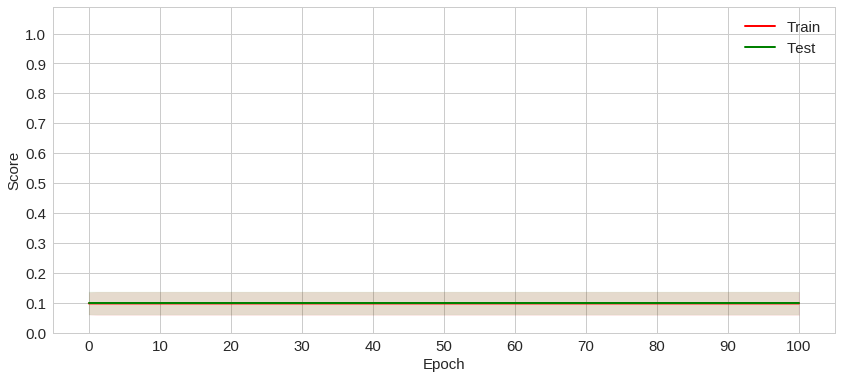

In [55]:
plot_mean_acc(tophistory)

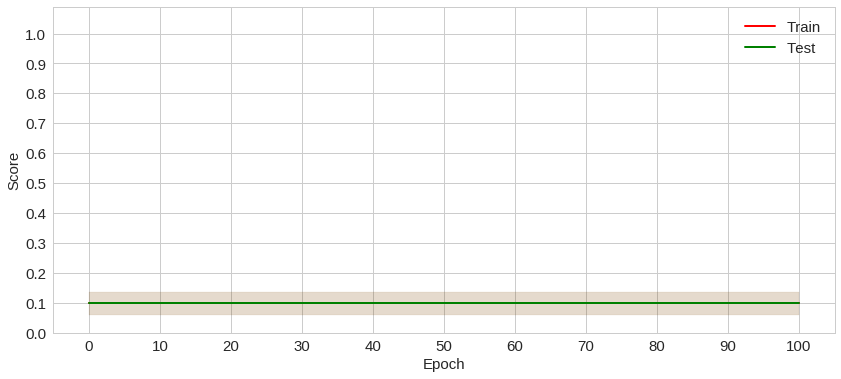

In [56]:
plot_mean_acc(history)

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

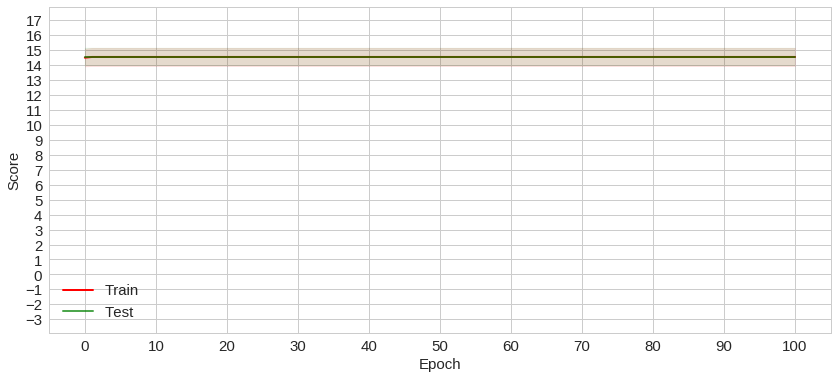

In [58]:
plot_mean_loss(tophistory)

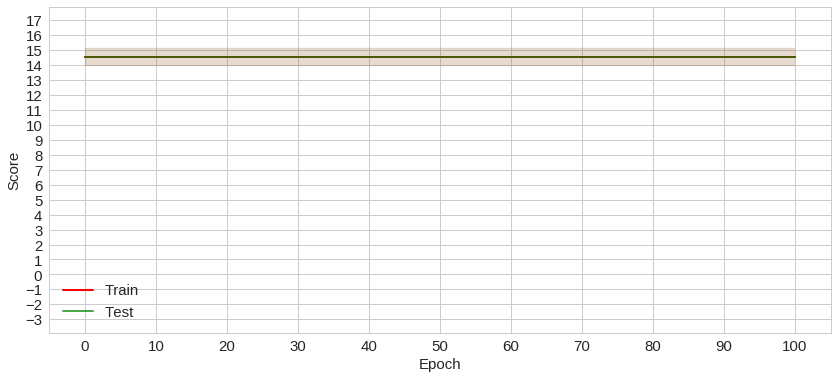

In [59]:
plot_mean_loss(history)